# 2016 VEST MI

### From Documentation:
Election results from the Michigan Department of State (https://miboecfr.nictusa.com/cgi-bin/cfr/precinct_srch.cgi)
Precinct shapefile from the Michigan Department of State (https://gis-michigan.opendata.arcgis.com/datasets/8ce0f3ce3ff74109ac02a26d34a0f4fc_1)

Michigan has cities split across counties. Two are relevant to their reported election results versus the precinct map (which did not make the split), Fenton and Richmond. Those precincts were merged to reflect the precinct map.

Most counties had "statistical adjustments" that were at the county level, rather than the precinct level. Only two were for party candidates (Huron and Kalkaka), and in those cases, two or fewer votes. The remaining cases were related to "other" votes. Due to the scattered nature of "other" votes, these votes are apportioned to precincts by the split of total votes of precincts within the county.

Detroit allows for absentee votes to be reported by Absentee Voter Counting Boards, which generally contain multiple precincts. These votes are apportioned to precincts by candidate in the same shares that the non-AVCB vote was split among precincts within a county. The linkage between election precinct and AVCB was provided by OpenElections via Derek Willis. Precinct 176 was listed as split between AVCB 37 and AVCB 158, the only precinct in the city that was listed as split. AVCB 158 has no other precinct assigned to it, so all votes went to precinct 176. However, this was a very low number of votes relative to the other AVCBs, so for ease of calculation, 176 was treated as a normal member of AVCB 37 in the disaggregation calculation described above.

G16PREDCli - Hillary Clinton (Democratic Party)
G16PRERTru - Donald J. Trump (Republican Party)
G16PREGSte - Jill Stein (Green Party)
G16PRELJoh - Gary Johnson (Libertarian Party)
G16PREOth - Other Candidates/Write-in Votes


**Files + Sources:** 

2016GEN.zip: Election precinct results from the Michigan Department of State (https://miboecfr.nictusa.com/cgi-bin/cfr/precinct_srch.cgi)

2016_Voting_Precincts-shp.zip: Precinct shapefile from the Michigan Department of State (https://gis-michigan.opendata.arcgis.com/datasets/8ce0f3ce3ff74109ac02a26d34a0f4fc_1)

mi_2016.zip: VEST final file (https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/NH5S2I/4KOZRU&version=46.0)

documentation_2016.txt: VEST's documentation on their 2016 work, all included, not just MI (https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/NH5S2I/A652IT&version=46.0)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Partner File

In [2]:
cd /Users/lilyfalk/sandbox/pdv-mi/vest-mi/vest_mi_2016_ar/

/Users/lilyfalk/sandbox/pdv-mi/vest-mi/vest_mi_2016_ar


In [3]:
gdfv = gpd.read_file('./raw-from-source/mi_2016/mi_2016.shp')
gdfv.head()

,VTD2016,Label,G16PREDCli,G16PRERTru,G16PREGSte,G16PRELJoh,G16PREOth,geometry
0,1632100000001,City of Dearborn,581,93,17,11,1,"POLYGON ((-83.14843 42.34469, -83.14861 42.343..."
1,1632100000002,City of Dearborn,560,95,23,9,3,"POLYGON ((-83.16029 42.34644, -83.16027 42.344..."
2,1632100000003,City of Dearborn,756,171,52,13,5,"POLYGON ((-83.16699 42.34247, -83.16815 42.342..."
3,1632100000004,City of Dearborn,406,70,17,8,1,"POLYGON ((-83.17687 42.34399, -83.17806 42.343..."
4,1632100000005,City of Dearborn,453,68,15,9,0,"POLYGON ((-83.18665 42.34561, -83.18657 42.343..."


# Shapefile

In [4]:
## Load, Project
shp = gpd.read_file('./raw-from-source/2016_Voting_Precincts/2016_Voting_Precincts.shp')
crs = gdfv.crs
shp = shp.to_crs(crs)
shp.head()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((-83.14843 42.34468, -83.14860 42.343..."
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((-83.16029 42.34643, -83.16026 42.344..."
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((-83.16699 42.34246, -83.16815 42.342..."
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((-83.17687 42.34398, -83.17806 42.343..."
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((-83.18665 42.34560, -83.18656 42.343..."


# Election Results

In [5]:
## Load + Process format

df = pd.read_csv('./raw-from-source/2016GEN/2016vote.txt', delimiter = '\t', header = None)
#columns defined in documentation
df.columns = ['election_year','election_type','office_code','district_code',
                                     'status_code','candidate_id','county_code','city_town_code','ward_number',
                                     'precinct_number','precinct_label','precinct_votes','na_col']
#Processing
#Filter to office code `1` for president
df = df[df['office_code'] == 1]
#Using the file `2016name.txt` to figure out these candidate codes: 
#- -1130    Stein
#- -1128    Clinton
#- -1110    Trump
#- -1101    Johnson

#Have to replace NaNs in `precinct_label` with empty strings so that we can use it as an index in the pivot
df['precinct_label'] = df['precinct_label'].replace(np.nan, '', regex = True)
## PIVOT RESULTS
df_pivot = df.pivot_table(index = ['county_code','city_town_code','ward_number','precinct_number','precinct_label'],
                         columns = ['candidate_id'],
                        values = ['precinct_votes'],
                         aggfunc = 'sum')
df_pivot.reset_index(inplace = True)

vote_cols_other = [( 'precinct_votes', -1142),
            ( 'precinct_votes', -1141),
            ( 'precinct_votes', -1140),
            ( 'precinct_votes', -1139),
            ( 'precinct_votes', -1137),
            ( 'precinct_votes', -1136),
            ( 'precinct_votes', -1135),
            ( 'precinct_votes', -1112),
            ( 'precinct_votes', -1108)]
df_pivot['G16PREOth'] = 0
for col in vote_cols_other:
    df_pivot['G16PREOth'] = df_pivot['G16PREOth'] + df_pivot[col]
    df_pivot.drop(col[1], axis = 1, level = 1, inplace = True)
    
df_pivot.reset_index(inplace = True)
df_pivot.columns = ['candidate_id','county_code','city_town_code','ward_number','precinct_number','precinct_label',
                              'G16PREGSte','G16PREDCli','G16PRERTru','G16PRELJoh','G16PREOth']
#Comparing results
print('Raw Election result column total sums:')
print(df_pivot[['G16PREDCli','G16PRERTru','G16PREGSte','G16PRELJoh','G16PREOth']].sum())
print('VEST column total sums:')
print(gdfv[['G16PREDCli','G16PRERTru','G16PREGSte','G16PRELJoh','G16PREOth']].sum())

Raw Election result column total sums:
G16PREDCli    2268839
G16PRERTru    2279543
G16PREGSte      51463
G16PRELJoh     172136
G16PREOth       27303
dtype: int64
VEST column total sums:
G16PREDCli    2268839
G16PRERTru    2279543
G16PREGSte      51463
G16PRELJoh     172136
G16PREOth       27303
dtype: int64


In [6]:
#testing example from below
print(df_pivot[df_pivot["candidate_id"]==378])

     candidate_id  county_code  city_town_code  ward_number  precinct_number  \
378           378           14              18            0                1   

    precinct_label  G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth  
378                         13         279         736          53          6  


## Cleaning Election Results

In [7]:
#### Add County Name
#The SOS results have county codes that are not FIPS codes. Pulled the `county.txt` file to a Sheet and lined it up with county fips codes from Wikipedia. Loading in this file created in Sheets. 
county_names = pd.read_csv('./raw-from-source/county_codes.csv', dtype = {'county_fips':'object'})
df_pivot = df_pivot.merge(county_names, on = 'county_code')

#### Add City/Township Name
#Loading in the `2016city.txt` file that has the corresponding names for the city codes in the election results file
city_codes = pd.read_csv('./raw-from-source/2016GEN/2016city.txt',delimiter='\t',header=None)
city_codes.columns = ['election_year','election_type','county_code','city_town_code','city_town_name','null']
city_codes.drop(['election_year','election_type','null'],axis=1,inplace=True)
df_pivot = df_pivot.merge(city_codes, on = ['county_code','city_town_code'])

In [8]:
print(df_pivot[df_pivot["candidate_id"]==378])

     candidate_id  county_code  city_town_code  ward_number  precinct_number  \
378           378           14              18            0                1   

    precinct_label  G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth  \
378                         13         279         736          53          6   

    county_name county_fips  city_town_name  
378        CASS         027  ONTWA TOWNSHIP  


# Looking for unique identifier

So, the elections file has 157 more unique identifiers than VEST's final file... Likely caused by satistical adjustments + AVCBs

In [9]:
print(set(gdfv.VTD2016) - set(shp.VTD2016))
print(set(shp.VTD2016) - set(gdfv.VTD2016))

set()
set()


See that `gdfv`, the final VEST file and `shp` the raw shapefile have unique identifiers that match up perfectly.

Check `gdfv` `VTD2016` column to identify different components of the unique id

Check census all geocodes file and find that `City of Dearborn` has `county_fips` = 163, and `county subdiv`(MCDFIPS) = 21000

So, from `shp`, `Jurisdicti` is the `county subdiv`/MCDFIPS code

## Read in Census File to get the MCDFIPs code and more

In [10]:
census = pd.read_csv('./raw-from-source/all-geocodes-v2016.csv')
censusmi = census[census['State Code (FIPS)'] == 26]
#After `Place Code` != 0, repeat values, so want to filter that out. Then see that # unique values = 1520 for County Sub, indicating same as `Juris` in `shp`
censusmi = censusmi[(censusmi['Place Code (FIPS)'] == 0) & (censusmi['County Subdivision Code (FIPS)'] != 0)]


Census file uses "Charter Township" whereas election df just says "Township". Also, census file says "City City" in some places

Seems like best bet is to make `Area Name`s consistent, make column with the county fips joined, then use dictionary to match to the `Juris` code

Before removing all instances of charter from the censusmi, wanted to make sure df does not contain instances, it doesnt
`df_pivot[df_pivot['city_town_name'].str.contains('charter')]
df_pivot[df_pivot['city_town_name'].str.contains('CITY CITY')]`

### Clean census file to make match column

In [11]:
censusmi['city_town_name'] = censusmi['Area Name (including legal/statistical area description)'].str.replace('charter township', 'township')
censusmi['city_town_name'] = censusmi['city_town_name'].str.replace('City city', 'city')
censusmi['city_town_name'] = censusmi['city_town_name'].str.upper()

#set(censusmi['city_town_name'].str.upper()) - set(df_pivot['city_town_name'])
#set(df_pivot['city_town_name']) - set(censusmi['city_town_name'].str.upper())
#Use^ to create dictionary below

census_to_df_city_dict = {'COLDSPRINGS TOWNSHIP': 'COLD SPRINGS TOWNSHIP',
 'DEWITT CITY': 'DE WITT CITY',
 'DEWITT TOWNSHIP': 'DE WITT TOWNSHIP',
 'GUN PLAIN TOWNSHIP': 'GUNPLAIN TOWNSHIP',
 "L'ANSE TOWNSHIP": 'LANSE TOWNSHIP',
 'LAGRANGE TOWNSHIP': 'LA GRANGE TOWNSHIP',
 'PLEASANTVIEW TOWNSHIP': 'PLEASANT VIEW TOWNSHIP',
 'ST. JAMES TOWNSHIP': 'ST JAMES TOWNSHIP',
 'VILLAGE OF CLARKSTON CITY': 'CLARKSTON CITY',
 'VILLAGE OF GROSSE POINTE SHORES CITY': 'GROSSE POINTE SHORES CITY'}

censusmi.loc[censusmi['city_town_name'].isin(census_to_df_city_dict.keys()), 'city_town_name'] = censusmi.loc[censusmi['city_town_name'].isin(census_to_df_city_dict.keys()), 'city_town_name'].map(census_to_df_city_dict)

#Use below to determine next needed replacements:
#df_pivot[(df_pivot['city_town_name'] == 'GROSS POINTE SHORES CITY') | (df_pivot['city_town_name'] == 'GROSSE POINTE SHORES CITY')]
#censusmi[(censusmi['city_town_name'] == 'GROSS POINTE SHORES CITY') | (censusmi['city_town_name'] == 'GROSSE POINTE SHORES CITY')]
censusmi.loc[(censusmi['Area Name (including legal/statistical area description)'] == 'Village of Grosse Pointe Shores city')&(censusmi['County Code (FIPS)']==99), 'city_town_name'] = 'GROSS POINTE SHORES CITY'


### Translate Census file JURISDICTION code in to df
Now that the city town names match, I can create a dictionary - census file juris code to df. First I need a column in each with the county code + the city town name

In [12]:
censusmi['county_city_id'] = censusmi['County Code (FIPS)'].astype(str).str.zfill(3) + censusmi['city_town_name']
df_pivot['county_city_id'] = df_pivot['county_fips'] + df_pivot['city_town_name']
#The census identifier has more values by 8 than the df, so just keep in mind when mapping.
### Apply dictionary to make column in df
county_city_id_to_mcdjuris_dict = pd.Series(censusmi['County Subdivision Code (FIPS)'].values, index = censusmi['county_city_id']).to_dict()
df_pivot['jurisd'] = (df_pivot['county_city_id'].map(county_city_id_to_mcdjuris_dict)).fillna(0).astype('int64')

#gdfv[gdfv['VTD2016'].str.slice(stop = 3) == '001'].head()
#From `gdfv` see that for juris for alcona twp, need 1040 --> 01040

### Compare df and gdfv size/unique id matching

In [13]:
print('# df id values with county, juris, prec#, no ward: ', (df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['precinct_number'].astype(str).str.zfill(3)).nunique())
print('gdfv shape: ', gdfv.shape)
print('# unique values in id with no ward: ', (gdfv['VTD2016'].str.slice(stop = -5) + gdfv['VTD2016'].str.slice(start = -3)).nunique())
### Observe better match rate with ward removed from unique identifier. Explore more about the unique ids:
print('# vals in gdfv not in df with no ward in id: ', len(set(gdfv['VTD2016'].str.slice(stop = -5) + gdfv['VTD2016'].str.slice(start = -3)) - set(df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['precinct_number'].astype(str).str.zfill(3))))
print('# vals in df not in gdfv with no ward in id: ', len(set(df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['precinct_number'].astype(str).str.zfill(3)) - set(gdfv['VTD2016'].str.slice(stop = 8) + gdfv['VTD2016'].str.slice(start = 10))))

# df id values with county, juris, prec#, no ward:  4950
gdfv shape:  (4810, 8)
# unique values in id with no ward:  4686
# vals in gdfv not in df with no ward in id:  53
# vals in df not in gdfv with no ward in id:  317


### Look more into ward use and needs for id creation
See from sample id that taking ward out, `VTD2016` does in fact rely on the ward # to make the id unique

In [14]:
#Observe highest value count for '00' in gdfv and df, but notice that the value counts do not match up - df has far too many '00' values
print('gdfv ward # value counts:')
print(gdfv['VTD2016'].str.slice(start = -5, stop = -3).value_counts())
print('df ward # value counts:')
print(df_pivot['ward_number'].value_counts())

gdfv ward # value counts:
00    3705
01     236
02     229
03     196
04     148
05     129
06      77
07      76
08       7
09       6
10       1
Name: VTD2016, dtype: int64
df ward # value counts:
0    4503
1     179
2     130
3     110
4      64
5      49
6      19
7      10
8       7
9       6
Name: ward_number, dtype: int64


In [15]:
#create draft id to match gdfv and shp that includes ward... will observe that the ward number does not match well with the other two files
df_pivot['VTD2016_draft'] = df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['ward_number'].astype(str).str.zfill(2) + df_pivot['precinct_number'].astype(str).str.zfill(3)+df_pivot['precinct_label'].str.strip()
#Observe poor match rate for this new draft id
print('# id values in shp not in df: ', len(set(shp.VTD2016) - set(df_pivot.VTD2016_draft)))
print('# id values in df not in shp: ', len(set(df_pivot.VTD2016_draft) - set(shp.VTD2016)))

#sum the difference in value counts for all ward #s not equal to zero
print('sum of ward# value count differences not equal to zero: ', (236-179)+ (229-130)+(196 - 110)+(148-64) + (129-49) + (77-19)+(76-10))
#See that half of mismatch can likely be attributed to ward mismatch

print('# ids in df not containing AVCB not in shp id list: ', len(set(df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.slice(start = -4)!='AVCB']) - set(shp.VTD2016)))


# id values in shp not in df:  567
# id values in df not in shp:  834
sum of ward# value count differences not equal to zero:  530
# ids in df not containing AVCB not in shp id list:  624


From `readme.txt`, see that `ward` field is 00 if "not applicable"...

See from removing AVCBs that match rate improves without - need to fix using csv from brian
TODO:
- modify AVCB as needed
- modify ward

In [16]:
#Observe 900 added to normal precinct values in the AVCBs
print('df AVCB values: ')
print(df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.slice(start = -4)=='AVCB'])

print('# unique ids in df and not avcb without ward: ', (df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.slice(start = -4)!='AVCB'].str.slice(stop=-5)+df_pivot['precinct_number'].astype(str).str.zfill(3)).nunique())
print('# unique ids in gdfv and not avcb without ward: ',(gdfv.VTD2016.str.slice(stop=-5)+gdfv.VTD2016.str.slice(start=-3)).nunique())

df AVCB values: 
380      0276090000901AVCB
386      0277394000901AVCB
494      0372412000901AVCB
865      0511218000901AVCB
1729     0874606000901AVCB
               ...        
4763    16322000001068AVCB
4764    16322000001069AVCB
4765    16322000001070AVCB
4766    16322000001071AVCB
4767    16322000001072AVCB
Name: VTD2016_draft, Length: 210, dtype: object
# unique ids in df and not avcb without ward:  4742
# unique ids in gdfv and not avcb without ward:  4686


ID Changes DICT is a dictionary added to make some minor ID adjustments to match more precincts.

In [17]:
id_changes_dict = {'0250592000021': '0250592002021', '0250592000010': '0250592001010', '0250592000008': '0250592005008', '0250592000006': '0250592004006', '0250592000012': '0250592002012', '0250592000005': '0250592005005', '0250592000015': '0250592003015', '0250592000016': '0250592003016', '0250592000003': '0250592005003', '0250592000018': '0250592002018', '0250592000014': '0250592004014', '0250592000023': '0250592001023', '0250592000020': '0250592005020', '0250592000017': '0250592003017', '0250592000007': '0250592002007', '0250592000013': '0250592004013', '0250592000001': '0250592003001', '0250592000002': '0250592004002', '0250592000004': '0250592001004', '0250592000022': '0250592001022', '0250592000019': '0250592003019', '0250592000009': '0250592004009', '0250592000011': '0250592005011', '0210752000003': '0210752003001', '0210752000001': '0210752001001', '0210752000004': '0210752004001', '0210752000002': '0210752002001', '1632200000490': '1632200001490', '1632200000489': '1632200006489', '1632200000488': '1632200006488', '1632200000487': '1632200006487', '1632200000486': '1632200006486', '1632200000485': '1632200006485', '1632200000484': '1632200006484', '1632200000483': '1632200006483', '1632200000482': '1632200006482', '1632200000481': '1632200006481', '1632200000480': '1632200006480', '1632200000479': '1632200006479', '1632200000478': '1632200006478', '1632200000477': '1632200006477', '1632200000476': '1632200006476', '1632200000475': '1632200006475', '1632200000474': '1632200006474', '1632200000473': '1632200006473', '1632200000472': '1632200006472', '1632200000471': '1632200006471', '1632200000470': '1632200006470', '1632200000469': '1632200006469', '1632200000468': '1632200006468', '1632200000467': '1632200006467', '1632200000466': '1632200006466', '1632200000465': '1632200006465', '1632200000464': '1632200006464', '1632200000463': '1632200006463', '1632200000462': '1632200006462', '1632200000461': '1632200006461', '1632200000460': '1632200006460', '1632200000459': '1632200006459', '1632200000458': '1632200006458', '1632200000457': '1632200006457', '1632200000456': '1632200005456', '1632200000455': '1632200005455', '1632200000454': '1632200005454', '1632200000453': '1632200006453', '1632200000452': '1632200005452', '1632200000451': '1632200006451', '1632200000450': '1632200006450', '1632200000449': '1632200005449', '1632200000448': '1632200005448', '1632200000447': '1632200005447', '1632200000446': '1632200005446', '1632200000445': '1632200005445', '1632200000444': '1632200005444', '1632200000443': '1632200005443', '1632200000442': '1632200005442', '1632200000441': '1632200005441', '1632200000440': '1632200005440', '1632200000439': '1632200005439', '1632200000438': '1632200005438', '1632200000437': '1632200005437', '1632200000436': '1632200005436', '1632200000435': '1632200005435', '1632200000434': '1632200005434', '1632200000433': '1632200005433', '1632200000432': '1632200005432', '1632200000431': '1632200007431', '1632200000430': '1632200007430', '1632200000429': '1632200007429', '1632200000428': '1632200007428', '1632200000427': '1632200007427', '1632200000426': '1632200007426', '1632200000425': '1632200006425', '1632200000424': '1632200006424', '1632200000423': '1632200006423', '1632200000422': '1632200006422', '1632200000421': '1632200006421', '1632200000420': '1632200006420', '1632200000419': '1632200006419', '1632200000418': '1632200006418', '1632200000417': '1632200006417', '1632200000416': '1632200006416', '1632200000415': '1632200007415', '1632200000414': '1632200007414', '1632200000413': '1632200007413', '1632200000412': '1632200007412', '1632200000411': '1632200007411', '1632200000410': '1632200007410', '1632200000409': '1632200007409', '1632200000408': '1632200007408', '1632200000407': '1632200007407', '1632200000406': '1632200007406', '1632200000405': '1632200007405', '1632200000404': '1632200007404', '1632200000403': '1632200002403', '1632200000402': '1632200007402', '1632200000401': '1632200007401', '1632200000400': '1632200007400', '1632200000399': '1632200007399', '1632200000398': '1632200007398', '1632200000397': '1632200007397', '1632200000396': '1632200007396', '1632200000395': '1632200007395', '1632200000394': '1632200007394', '1632200000393': '1632200007393', '1632200000392': '1632200002392', '1632200000391': '1632200002391', '1632200000390': '1632200007390', '1632200000389': '1632200002389', '1632200000388': '1632200002388', '1632200000387': '1632200002387', '1632200000386': '1632200002386', '1632200000385': '1632200002385', '1632200000384': '1632200002384', '1632200000383': '1632200002383', '1632200000382': '1632200002382', '1632200000381': '1632200002381', '1632200000380': '1632200002380', '1632200000379': '1632200001379', '1632200000378': '1632200001378', '1632200000377': '1632200007377', '1632200000376': '1632200007376', '1632200000375': '1632200007375', '1632200000374': '1632200007374', '1632200000373': '1632200007373', '1632200000372': '1632200007372', '1632200000371': '1632200007371', '1632200000370': '1632200007370', '1632200000369': '1632200007369', '1632200000368': '1632200007368', '1632200000367': '1632200007367', '1632200000366': '1632200007366', '1632200000365': '1632200007365', '1632200000364': '1632200007364', '1632200000363': '1632200007363', '1632200000362': '1632200001362', '1632200000361': '1632200001361', '1632200000360': '1632200001360', '1632200000359': '1632200001359', '1632200000358': '1632200001358', '1632200000357': '1632200001357', '1632200000356': '1632200007356', '1632200000355': '1632200007355', '1632200000354': '1632200001354', '1632200000353': '1632200001353', '1632200000352': '1632200001352', '1632200000351': '1632200001351', '1632200000350': '1632200001350', '1632200000349': '1632200007349', '1632200000348': '1632200007348', '1632200000347': '1632200007347', '1632200000346': '1632200007346', '1632200000345': '1632200007345', '1632200000344': '1632200007344', '1632200000343': '1632200007343',
                     '1632200000342': '1632200007342', '1632200000341': '1632200007341', '1632200000340': '1632200007340', '1632200000339': '1632200007339', '1632200000338': '1632200007338', '1632200000337': '1632200007337', '1632200000336': '1632200007336', '1632200000335': '1632200007335', '1632200000334': '1632200007334', '1632200000333': '1632200007333', '1632200000332': '1632200007332', '1632200000331': '1632200007331', '1632200000330': '1632200007330', '1632200000329': '1632200001329', '1632200000328': '1632200001328', '1632200000327': '1632200001327', '1632200000326': '1632200001326', '1632200000325': '1632200001325', '1632200000324': '1632200001324', '1632200000323': '1632200001323', '1632200000322': '1632200001322', '1632200000321': '1632200001321', '1632200000320': '1632200001320', '1632200000319': '1632200001319', '1632200000318': '1632200001318', '1632200000317': '1632200001317', '1632200000316': '1632200001316', '1632200000315': '1632200001315', '1632200000314': '1632200002314', '1632200000313': '1632200002313', '1632200000312': '1632200001312', '1632200000311': '1632200001311', '1632200000310': '1632200001310', '1632200000309': '1632200001309', '1632200000308': '1632200001308', '1632200000307': '1632200001307', '1632200000306': '1632200001306', '1632200000305': '1632200001305', '1632200000304': '1632200001304', '1632200000303': '1632200001303', '1632200000302': '1632200001302', '1632200000301': '1632200001301', '1632200000300': '1632200001300', '1632200000299': '1632200001299', '1632200000298': '1632200001298', '1632200000297': '1632200001297', '1632200000296': '1632200002296', '1632200000295': '1632200002295', '1632200000294': '1632200002294', '1632200000293': '1632200002293', '1632200000292': '1632200002292', '1632200000291': '1632200002291', '1632200000290': '1632200002290', '1632200000289': '1632200002289', '1632200000288': '1632200002288', '1632200000287': '1632200001287', '1632200000286': '1632200001286', '1632200000285': '1632200001285', '1632200000284': '1632200001284', '1632200000283': '1632200001283', '1632200000282': '1632200001282', '1632200000281': '1632200001281', '1632200000280': '1632200001280', '1632200000279': '1632200001279', '1632200000278': '1632200001278', '1632200000277': '1632200001277', '1632200000276': '1632200001276', '1632200000275': '1632200001275', '1632200000274': '1632200001274', '1632200000273': '1632200001273', '1632200000272': '1632200001272', '1632200000271': '1632200001271', '1632200000270': '1632200001270', '1632200000269': '1632200001269', '1632200000268': '1632200001268', '1632200000267': '1632200001267', '1632200000266': '1632200001266', '1632200000265': '1632200001265', '1632200000264': '1632200001264', '1632200000263': '1632200001263', '1632200000262': '1632200001262', '1632200000261': '1632200001261', '1632200000260': '1632200002260', '1632200000259': '1632200002259', '1632200000258': '1632200002258', '1632200000257': '1632200002257', '1632200000256': '1632200002256', '1632200000255': '1632200002255', '1632200000254': '1632200001254', '1632200000253': '1632200001253', '1632200000252': '1632200001252', '1632200000251': '1632200001251', '1632200000250': '1632200002250', '1632200000249': '1632200002249', '1632200000248': '1632200002248', '1632200000247': '1632200002247', '1632200000246': '1632200002246', '1632200000245': '1632200002245', '1632200000244': '1632200002244', '1632200000243': '1632200002243', '1632200000242': '1632200002242', '1632200000241': '1632200002241', '1632200000240': '1632200002240', '1632200000239': '1632200002239', '1632200000238': '1632200002238', '1632200000237': '1632200002237', '1632200000236': '1632200002236', '1632200000235': '1632200002235', '1632200000234': '1632200002234', '1632200000233': '1632200002233', '1632200000232': '1632200002232', '1632200000231': '1632200002231', '1632200000230': '1632200002230', '1632200000229': '1632200002229', '1632200000228': '1632200002228', '1632200000227': '1632200002227', '1632200000226': '1632200002226', '1632200000225': '1632200002225', '1632200000224': '1632200002224', '1632200000223': '1632200002223', '1632200000222': '1632200002222', '1632200000221': '1632200002221', '1632200000220': '1632200005220', '1632200000219': '1632200002219', '1632200000218': '1632200005218', '1632200000217': '1632200002217', '1632200000216': '1632200002216', '1632200000215': '1632200002215', '1632200000214': '1632200002214', '1632200000213': '1632200002213', '1632200000212': '1632200002212', '1632200000211': '1632200002211', '1632200000210': '1632200002210', '1632200000209': '1632200002209', '1632200000208': '1632200002208', '1632200000207': '1632200002207', '1632200000206': '1632200002206', '1632200000205': '1632200002205', '1632200000204': '1632200002204', '1632200000203': '1632200002203', '1632200000202': '1632200002202', '1632200000201': '1632200002201', '1632200000200': '1632200002200', '1632200000199': '1632200002199', '1632200000198': '1632200002198', '1632200000197': '1632200003197', '1632200000196': '1632200003196', '1632200000195': '1632200003195', '1632200000194': '1632200003194', '1632200000193': '1632200003193', '1632200000192': '1632200003192', '1632200000191': '1632200003191', '1632200000190': '1632200003190', '1632200000189': '1632200003189', '1632200000188': '1632200003188', '1632200000187': '1632200003187', '1632200000186': '1632200003186', '1632200000185': '1632200003185', '1632200000184': '1632200003184', '1632200000183': '1632200003183', '1632200000182': '1632200003182', '1632200000181': '1632200003181', '1632200000180': '1632200003180', '1632200000179': '1632200003179', '1632200000178': '1632200003178', '1632200000177': '1632200003177', '1632200000176': '1632200003176', '1632200000175': '1632200003175', '1632200000174': '1632200003174', '1632200000173': '1632200003173', '1632200000172': '1632200003172', '1632200000171': '1632200005171', '1632200000170': '1632200005170', '1632200000169': '1632200005169', '1632200000168': '1632200005168', '1632200000167': '1632200005167', '1632200000166': '1632200005166', '1632200000165': '1632200005165', '1632200000164': '1632200005164', '1632200000163': '1632200005163', '1632200000162': '1632200005162', '1632200000161': '1632200005161', '1632200000160': '1632200005160', '1632200000159': '1632200005159', '1632200000158': '1632200005158', '1632200000157': '1632200006157', '1632200000156': '1632200005156', '1632200000155': '1632200005155', '1632200000154': '1632200006154', '1632200000153': '1632200006153', '1632200000152': '1632200005152', '1632200000151': '1632200006151', '1632200000150': '1632200006150', '1632200000149': '1632200006149', '1632200000148': '1632200006148', '1632200000147': '1632200006147', '1632200000146': '1632200006146', '1632200000145': '1632200006145', '1632200000144': '1632200006144', '1632200000143': '1632200006143', '1632200000142': '1632200005142', '1632200000141': '1632200005141', '1632200000140': '1632200005140', '1632200000139': '1632200005139', '1632200000138': '1632200005138', '1632200000137': '1632200005137', '1632200000136': '1632200005136', '1632200000135': '1632200005135', '1632200000134': '1632200005134', '1632200000133': '1632200005133', '1632200000132': '1632200005132', '1632200000131': '1632200005131', '1632200000130': '1632200005130', '1632200000129': '1632200005129', '1632200000128': '1632200005128', '1632200000127': '1632200005127', '1632200000126': '1632200005126', '1632200000125': '1632200005125', '1632200000124': '1632200005124', '1632200000123': '1632200005123', '1632200000122': '1632200005122', '1632200000121': '1632200005121', '1632200000120': '1632200005120', '1632200000119': '1632200005119', '1632200000118': '1632200005118', '1632200000117': '1632200005117', '1632200000116': '1632200005116', '1632200000115': '1632200005115', '1632200000114': '1632200004114', '1632200000113': '1632200004113', '1632200000112': '1632200004112', '1632200000111': '1632200004111', '1632200000110': '1632200004110', '1632200000109': '1632200004109', '1632200000108': '1632200003108', '1632200000107': '1632200003107', '1632200000106': '1632200004106', '1632200000105': '1632200004105', '1632200000104': '1632200004104', '1632200000103': '1632200004103', '1632200000102': '1632200003102', '1632200000101': '1632200003101', '1632200000100': '1632200003100', '1632200000099': '1632200005099', '1632200000098': '1632200005098', '1632200000097': '1632200003097', '1632200000096': '1632200003096', '1632200000095': '1632200003095', '1632200000094': '1632200003094', '1632200000093': '1632200003093', '1632200000092': '1632200003092', '1632200000091': '1632200003091', '1632200000090': '1632200003090', '1632200000089': '1632200003089', '1632200000088': '1632200003088', '1632200000087': '1632200003087', '1632200000086': '1632200003086', '1632200000085': '1632200003085', '1632200000084': '1632200003084', '1632200000083': '1632200003083',
                     '1632200000082': '1632200003082', '1632200000081': '1632200003081', '1632200000080': '1632200003080', '1632200000079': '1632200003079', '1632200000078': '1632200003078', '1632200000077': '1632200003077', '1632200000076': '1632200004076', '1632200000075': '1632200003075', '1632200000074': '1632200003074', '1632200000073': '1632200003073', '1632200000072': '1632200003072', '1632200000071': '1632200003071', '1632200000070': '1632200003070', '1632200000069': '1632200003069', '1632200000068': '1632200003068', '1632200000067': '1632200003067', '1632200000066': '1632200003066', '1632200000065': '1632200003065', '1632200000064': '1632200003064', '1632200000063': '1632200003063', '1632200000062': '1632200003062', '1632200000061': '1632200003061', '1632200000060': '1632200004060', '1632200000059': '1632200004059', '1632200000058': '1632200004058', '1632200000057': '1632200004057', '1632200000056': '1632200004056', '1632200000055': '1632200004055', '1632200000054': '1632200004054', '1632200000053': '1632200004053', '1632200000052': '1632200004052', '1632200000051': '1632200004051', '1632200000050': '1632200004050', '1632200000049': '1632200004049', '1632200000048': '1632200004048', '1632200000047': '1632200004047', '1632200000046': '1632200004046', '1632200000045': '1632200004045', '1632200000044': '1632200004044', '1632200000043': '1632200004043', '1632200000042': '1632200004042', '1632200000041': '1632200004041', '1632200000040': '1632200004040', '1632200000039': '1632200004039', '1632200000038': '1632200004038', '1632200000037': '1632200004037', '1632200000036': '1632200004036', '1632200000035': '1632200004035', '1632200000034': '1632200004034', '1632200000033': '1632200004033', '1632200000032': '1632200004032', '1632200000031': '1632200004031', '1632200000030': '1632200004030', '1632200000029': '1632200004029', '1632200000028': '1632200004028', '1632200000027': '1632200004027', '1632200000026': '1632200004026', '1632200000025': '1632200004025', '1632200000024': '1632200004024', '1632200000023': '1632200004023', '1632200000022': '1632200004022', '1632200000021': '1632200004021', '1632200000020': '1632200004020', '1632200000019': '1632200004019', '1632200000018': '1632200004018', '1632200000017': '1632200004017', '1632200000016': '1632200004016', '1632200000015': '1632200004015', '1632200000014': '1632200004014', '1632200000013': '1632200004013', '1632200000012': '1632200004012', '1632200000011': '1632200004011', '1632200000010': '1632200004010', '1632200000009': '1632200004009', '1632200000008': '1632200004008', '1632200000007': '1632200004007', '1632200000006': '1632200004006', '1632200000005': '1632200004005', '1632200000004': '1632200004004', '1632200000003': '1632200005003', '1632200000002': '1632200005002', '1632200000001': '1632200005001', '1373172002002': '1373172002001', '1373172003003': '1373172003001', '0513232001003': '0513232003002', '0513232001004': '0513232004001', '0513232001002': '0513232002002', '0153712000001': '01537120010001', '0674086004004': '0674086004001', '0674086003003': '0674086003001', '0674086002002': '0674086002001', '0434096000002': '0434096002002', '0434096000001': '0434096001003', '0434096000003': '0434096003002', '045460000300023': '0454600003023', '045460000300022L': '0454600003022', '1155502000003': '1155502000003N', '0215776000004': '0215776004004', '0215776000002': '0215776002002', '0215776000003': '0215776003003', '0215776000001': '0215776001001', '0370000000001': '0376186000001', '0476382000002': '0476382002001', '0476382000001': '0476382001001', '0476382000003': '0476382003001', '0476382000004': '0476382004001', '1256903501009': '1256903502009', '1256903501030': '1256903504030', '1256903501028': '1256903504028', '1256903501001': '1256903503001', '1256903501016': '1256903503016', '1256903501025': '1256903502025', '1256903501012': '1256903503012', '1256903501024': '1256903503024', '1256903501010': '1256903502010', '1256903501027': '1256903504027', '1256903501032': '1256903502032', '1256903501005': '1256903504005', '1256903501021': '1256903502021', '1256903501031': '1256903503031', '1256903501011': '1256903504011', '1256903501003': '1256903503003', '1256903501004': '1256903502004', '1256903501018': '1256903502018', '1256903501019': '1256903502019', '1256903501013': '1256903503013', '1256903501020': '1256903504020', '1256903501002': '1256903503002', '1256903501015': '1256903504015', '1256903501007': '1256903502007', '0057498000001': '0057498003002'}
print('ID change dict length: ', len(id_changes_dict))
#Using the VTD2016 column as the unique ID and applying the dictioanry above
df_pivot["VTD2016"] = df_pivot["VTD2016_draft"]
df_pivot["VTD2016"] = df_pivot["VTD2016"].map(id_changes_dict).fillna(df_pivot["VTD2016"])

ID change dict length:  566


# Deal with AVCBs and statistical adjustments
## There are 3 different steps:

1. Deal with non-Detroit (Wayne County) AVCBS - these votes need to be added directly to the precincts they correspond to 
2. Deal with Detroit AVCBs - these need to be allocated based on a precincts share of votes within the AVCB it is covered by
3. Deal with statistical adjustments - these apply to all precincts and can be dealt with all at once

Notice that
- precinct # - 900 = precinctid from csv -

Make into dictionary, use .loc to apply to precinct_number, then make new VTD 2016

In [18]:
#Split up the AVCB, statistical adjustments, and precinct level votes, to both check the join and for the allocation work that needs to be done
avcb = df_pivot[df_pivot['precinct_label'].map(lambda x: 'AVCB' in str(x))]

stat = df_pivot[df_pivot['city_town_name'].map(lambda x: 'Statistical Adjustments' in str(x))]

df_no_avcb_or_stat = df_pivot[(df_pivot['precinct_label'].map(lambda x: 'AVCB' not in str(x))) & 
                              (df_pivot['city_town_name'].map(lambda x: 'Statistical Adjustments' not in str(x)))]

In [89]:
avcb["county_name"].unique()

array(['CASS', 'CLINTON', 'GLADWIN', 'LAPEER', 'ST. CLAIR', 'WAYNE'],
      dtype=object)

In [19]:
avcb["county_name"].unique()
avcb_wayne = avcb[avcb["county_name"]=="WAYNE"]
avcb_not_wayne = avcb[avcb["county_name"]!="WAYNE"]
print(avcb_not_wayne)

      candidate_id  county_code  city_town_code  ward_number  precinct_number  \
380            380           14              18            0              901   
386            386           14              26            0              901   
494            494           19              15            0              901   
865            865           26              12            0              901   
1729          1729           44              24            0              901   
1730          1730           44              24            0              902   
3485          3485           74              12            0              901   
3486          3486           74              12            0              903   
3487          3487           74              12            0              904   
3488          3488           74              12            0              905   
3496          3496           74              20            0              901   
3497          3497          

In [20]:
#print(avcb_not_wayne["VTD2016"])
avcb_vtds_list_for_nonwayne = list(avcb_not_wayne["VTD2016"])
print(avcb_vtds_list_for_nonwayne)

['0276090000901AVCB', '0277394000901AVCB', '0372412000901AVCB', '0511218000901AVCB', '0874606000901AVCB', '0874606000902AVCB', '1471618000901AVCB', '1471618000903AVCB', '1471618000904AVCB', '1471618000905AVCB', '1472382000901AVCB', '1472382000902AVCB', '1474092000901AVCB', '1474092000902AVCB', '1474092000903AVCB', '1476584000901AVCB', '1476584000902AVCB', '1476584000903AVCB', '1476584000904AVCB', '1476584000905AVCB', '1477070000901AVCB', '1477070000902AVCB', '1475208000901AVCB', '1475208000902AVCB', '1475208000903AVCB', '1476582000901AVCB', '1476582000902AVCB', '1476582000903AVCB', '1476582000904AVCB', '1476582000905AVCB', '1476582000906AVCB', '1476582000907AVCB', '1476582000908AVCB', '1476582000909AVCB', '1476582000910AVCB', '1477068000901AVCB', '1477068000902AVCB', '1477068000903AVCB']


In [21]:
df_no_avcb_or_stat[df_no_avcb_or_stat["VTD2016"].isin(avcb_vtds_list_for_nonwayne)]
for i in avcb_vtds_list_for_nonwayne:
    if i not in list(df_no_avcb_or_stat["VTD2016"]):
        print(i)

0276090000901AVCB
0277394000901AVCB
0372412000901AVCB
0511218000901AVCB
0874606000901AVCB
0874606000902AVCB
1471618000901AVCB
1471618000903AVCB
1471618000904AVCB
1471618000905AVCB
1472382000901AVCB
1472382000902AVCB
1474092000901AVCB
1474092000902AVCB
1474092000903AVCB
1476584000901AVCB
1476584000902AVCB
1476584000903AVCB
1476584000904AVCB
1476584000905AVCB
1477070000901AVCB
1477070000902AVCB
1475208000901AVCB
1475208000902AVCB
1475208000903AVCB
1476582000901AVCB
1476582000902AVCB
1476582000903AVCB
1476582000904AVCB
1476582000905AVCB
1476582000906AVCB
1476582000907AVCB
1476582000908AVCB
1476582000909AVCB
1476582000910AVCB
1477068000901AVCB
1477068000902AVCB
1477068000903AVCB


In [22]:
##There is no precinct that directly corresponds with the AVCB precinct with the VTD2016 of "0372412000001". However, as shown below, 
#there is only one precinct that covers East Lansing City and is in Clinton County. We are assuming that is where the votes should be added to.
avcb_not_wayne.loc[avcb_not_wayne["VTD2016"]=="0372412000001"]

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016


In [23]:
df_no_avcb_or_stat.loc[(df_no_avcb_or_stat["city_town_name"]=="EAST LANSING CITY") & (df_no_avcb_or_stat["county_fips"]=="037")]

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016
493,493,19,15,0,17,,7,501,163,18,0,CLINTON,037,EAST LANSING CITY,037EAST LANSING CITY,24120,0372412000017,0372412000017


## Add non-Wayne AVCB's directly to their corresponding precinct

Note: For "0372412000001", the votes are added to a different precinct that was found manually, as described above. Otherwise, the AVCB votes are added to the precinct with the same name.

In [24]:
#Non-Wayne county reallocation
data_columns = ["G16PREGSte","G16PREDCli","G16PRERTru","G16PRELJoh","G16PREOth"]

for i in avcb_vtds_list_for_nonwayne:
    if i =='0372412000001':
        df_id = '0372412000017'
    else:
        df_id = i
    for cand in data_columns:
        df_no_avcb_or_stat.loc[df_no_avcb_or_stat["VTD2016"]==df_id,cand]+=int(avcb_not_wayne.loc[avcb_not_wayne["VTD2016"]==i,cand])

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Allocate Wayne AVCB's using csv file from Brian Amos

In [25]:
avcb_csv = pd.read_csv('./raw-from-source/detroit16_readable.csv', names=['prec_num', 'avcb_num'])
avcb_csv_dict = dict(zip(avcb_csv['prec_num'], avcb_csv['avcb_num']))

In [26]:
#replace avcb values for non-detroit locations by replacing 9 with 0 in order to match the csv file precinct numbers
df_pivot.loc[(df_pivot['VTD2016_draft'].str.endswith('AVCB'))&(df_pivot['city_town_name']!='DETROIT CITY'), 'VTD2016']= df_pivot['VTD2016_draft'].str.slice(stop=-7)+ '0'+df_pivot['VTD2016_draft'].str.slice(start=-6,stop=-4) 

In [27]:
precincts_detroit = df_no_avcb_or_stat[df_no_avcb_or_stat["city_town_name"]=="DETROIT CITY"]
precincts_not_detroit = df_no_avcb_or_stat[df_no_avcb_or_stat["city_town_name"]!="DETROIT CITY"]

In [28]:
precincts_detroit

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016
4106,4106,82,57,0,1,,1,272,10,1,1,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000001,1632200005001
4107,4107,82,57,0,2,,6,398,12,10,2,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000002,1632200005002
4108,4108,82,57,0,3,,0,460,7,2,2,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000003,1632200005003
4109,4109,82,57,0,4,,1,284,5,1,0,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000004,1632200004004
4110,4110,82,57,0,5,,0,322,9,1,1,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000005,1632200004005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4591,4591,82,57,0,486,,1,123,6,0,0,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000486,1632200006486
4592,4592,82,57,0,487,,1,91,15,1,0,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000487,1632200006487
4593,4593,82,57,0,488,,3,276,71,4,0,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000488,1632200006488
4594,4594,82,57,0,489,,3,120,28,5,0,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000489,1632200006489


In [29]:
#Define a new column called avcb to store what avcb a precinct is covered by, set it to 0 to start
precincts_detroit["avcb"]=0

#Use the dictionary above, which maps from precinct number to avcb, to find the avcb for each precinct
precincts_detroit.loc[:,"avcb"] = precincts_detroit["precinct_number"].map(avcb_csv_dict).fillna(precincts_detroit["avcb"])

<ipython-input-29-f87a0945e864>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precincts_detroit["avcb"]=0
/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [30]:
#The number of avcbs that have been mapped to, should equal the number of avcbs (172)
print('# avcbs that have been mapped:', len(precincts_detroit["avcb"].unique()))

print('avcb_wayne shapre: ', avcb_wayne.shape)

# avcbs that have been mapped: 172
avcb_wayne shapre:  (172, 18)


In [31]:
#Checked that all rows were accounted in for in splitting the dataframe up

#What we started with
print('df_pivot from pre avcb manipulation shape: ', df_pivot.shape)

#Will be used as part of allocation
print('avcb only df shape: ' , avcb.shape)
print('stat only df shape: ', stat.shape)

#Where the allocated votes will be added to
print('not detroit precincts shape: ', precincts_not_detroit.shape)
print('detroit precincts shape: ', precincts_detroit.shape)
print('sum of parts: ', avcb.shape[0]+ stat.shape[0]+ precincts_not_detroit.shape[0]+ precincts_detroit.shape[0])

df_pivot from pre avcb manipulation shape:  (5077, 18)
avcb only df shape:  (210, 18)
stat only df shape:  (56, 18)
not detroit precincts shape:  (4321, 18)
detroit precincts shape:  (490, 19)
sum of parts:  5077


### Addressing documentation note on specific Detroit precincts:

Precinct 176 was listed as split between AVCB 37 and AVCB 158, the only precinct in the city that was listed as split. AVCB 158 has no other precinct assigned to it, so all votes went to precinct 176. However, this was a very low number of votes relative to the other AVCBs, so for ease of calculation, 176 was treated as a normal member of AVCB 37 in the disaggregation calculation described above.

In [32]:
print(len(precincts_detroit["avcb"].unique()))

172


In [33]:
precincts_detroit
avcb_wayne["precinct_number"].unique()
avcb_wayne["avcb"] = 0
avcb_wayne.loc[:,"avcb"] = avcb_wayne.loc[:,"precinct_number"]-900
print(avcb_wayne["avcb"].unique())

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172]


<ipython-input-33-f6d8aaf9b33a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avcb_wayne["avcb"] = 0


In [34]:
avcb_wayne.loc[avcb_wayne["avcb"]==158]

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016,avcb
4753,4753,82,57,0,1058,AVCB,0,27,0,0,0,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,16322000001058AVCB,16322000001058AVCB,158


In [35]:
precincts_detroit.loc[precincts_detroit["avcb"]=='37/158']

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016,avcb
4281,4281,82,57,0,176,,2,365,3,2,2,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000176,1632200003176,37/158


In [36]:
precincts_detroit.loc[precincts_detroit["avcb"]=='37/158',"G16PREDCli"]+=27
precincts_detroit.loc[precincts_detroit["avcb"]=='37/158',"G16PREDCli"]

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


4281    392
Name: G16PREDCli, dtype: int64

In [37]:
avcb_wayne = avcb_wayne[avcb_wayne["avcb"]!=158]

In [38]:
avcb_adj_dict = {'37/158':'37'}
precincts_detroit["avcb"]= precincts_detroit["avcb"].map(avcb_adj_dict).fillna(precincts_detroit["avcb"])

<ipython-input-38-3d4e94624abf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precincts_detroit["avcb"]= precincts_detroit["avcb"].map(avcb_adj_dict).fillna(precincts_detroit["avcb"])


In [39]:
## Reallocate wayne county avcb votes

to_dole_out_totals = avcb_wayne.groupby(["avcb"]).sum()

print(to_dole_out_totals)
precinct_specific_totals = precincts_detroit.groupby(["avcb"]).sum()
precinct_specific_totals.reset_index(inplace=True, drop=False)
to_dole_out_totals.reset_index(inplace=True, drop=False)
column_list = ['G16PREGSte', 'G16PREDCli', 'G16PRERTru', 'G16PRELJoh', 'G16PREOth']

to_dole_out_totals["avcb"] = to_dole_out_totals["avcb"].astype(str)
precinct_specific_totals["avcb"] = precinct_specific_totals["avcb"].astype(str)

#Create some new columns for each of these races to deal with the allocation
for race in column_list:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    precincts_detroit.loc[:,add_var]=0.0
    precincts_detroit.loc[:,rem_var]=0.0
    precincts_detroit.loc[:,floor_var]=0.0
    
#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate

for index, row in precincts_detroit.iterrows():
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["county_fips"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["avcb"]==county_id][race]
        
        if county_id in list(to_dole_out_totals['avcb']):
            #Get one of the numerators, how many district-wide votes to allocate
            numer = to_dole_out_totals.loc[to_dole_out_totals["avcb"]==county_id][race]
            #Get the vote totals for this race in this precinct
            val = precincts_detroit.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
            if ((float(denom)==0)):
                vote_share = 0
            else:
                vote_share = (float(val)/float(denom))*float(numer)
            precincts_detroit.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            precincts_detroit.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            precincts_detroit.at[index,floor_var] = np.floor(vote_share)
            
#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(precincts_detroit.groupby(["avcb"]).sum())
first_allocation.reset_index(inplace=True,drop=False)

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["avcb"].unique()) 

#Iterate over the district
for county in county_list:
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #print(int(to_dole_out_totals.loc[to_dole_out_totals["avcb"]==county][race]))
        #print(int(first_allocation.loc[first_allocation.index==county][floor_var]))
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["avcb"]==county][race])-int(first_allocation.loc[first_allocation["avcb"]==county,floor_var]))))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in precincts_detroit.loc[precincts_detroit["avcb"]==county][rem_var].nlargest(to_go).index:
            precincts_detroit.at[index,add_var] = np.ceil(precincts_detroit.at[index,add_var])
            
#Iterate over every race again
for race in column_list:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    precincts_detroit.loc[:,add_var]=np.floor(precincts_detroit.loc[:,add_var])
    precincts_detroit.loc[:,race]+=precincts_detroit.loc[:,add_var]

      candidate_id  county_code  city_town_code  ward_number  precinct_number  \
avcb                                                                            
1             4596           82              57            0              901   
2             4597           82              57            0              902   
3             4598           82              57            0              903   
4             4599           82              57            0              904   
5             4600           82              57            0              905   
...            ...          ...             ...          ...              ...   
168           4763           82              57            0             1068   
169           4764           82              57            0             1069   
170           4765           82              57            0             1070   
171           4766           82              57            0             1071   
172           4767          

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [40]:
precincts_detroit = precincts_detroit[['candidate_id', 'county_code', 'city_town_code', 'ward_number',
       'precinct_number', 'precinct_label', 'G16PREGSte', 'G16PREDCli',
       'G16PRERTru', 'G16PRELJoh', 'G16PREOth', 'county_name', 'county_fips',
       'city_town_name', 'county_city_id', 'jurisd', 'VTD2016_draft',
       'VTD2016']]

In [41]:
df_with_avcb_reallocated_need_stat_adjust = pd.concat([precincts_not_detroit,precincts_detroit])

## Now that avcbs reallocated, reallocate statistical adjustments

In [42]:
#Copy dfs to set up for reallocation to create new df
df_with_avcb_and_stat_reallocated = df_with_avcb_reallocated_need_stat_adjust.copy()
to_dole_out_totals = stat[['county_fips','G16PREGSte', 'G16PREDCli', 'G16PRERTru', 'G16PRELJoh', 'G16PREOth']].groupby(['county_fips']).sum()

precinct_specific_totals = df_with_avcb_and_stat_reallocated.groupby(['county_fips']).sum()
precinct_specific_totals.reset_index(inplace=True, drop=False)
to_dole_out_totals.reset_index(inplace=True, drop=False)

column_list = ['G16PREGSte', 'G16PREDCli', 'G16PRERTru', 'G16PRELJoh', 'G16PREOth']

#Create some new columns for each of these races to deal with the allocation
for race in column_list:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    df_with_avcb_and_stat_reallocated.loc[:,add_var]=0.0
    df_with_avcb_and_stat_reallocated.loc[:,rem_var]=0.0
    df_with_avcb_and_stat_reallocated.loc[:,floor_var]=0.0
    
#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate

for index, row in df_no_avcb_or_stat.iterrows():
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["county_fips"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["county_fips"]==county_id][race]
        
        if county_id in list(to_dole_out_totals['county_fips']):
            #Get one of the numerators, how many district-wide votes to allocate
            numer = to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==county_id][race]
            #Get the vote totals for this race in this precinct
            val = df_with_avcb_and_stat_reallocated.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
            if ((float(denom)==0)):
                vote_share = 0
            else:
                vote_share = (float(val)/float(denom))*float(numer)
            df_with_avcb_and_stat_reallocated.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            df_with_avcb_and_stat_reallocated.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            df_with_avcb_and_stat_reallocated.at[index,floor_var] = np.floor(vote_share)
            
#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(df_with_avcb_and_stat_reallocated.groupby(["county_fips"]).sum())

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["county_fips"].unique()) 

#Iterate over the district
for county in county_list:
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in df_with_avcb_and_stat_reallocated.loc[df_with_avcb_and_stat_reallocated["county_fips"]==county][rem_var].nlargest(to_go).index:
            df_with_avcb_and_stat_reallocated.at[index,add_var] = np.ceil(df_with_avcb_and_stat_reallocated.at[index,add_var])
            
#Iterate over every race again
for race in column_list:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    df_with_avcb_and_stat_reallocated.loc[:,add_var]=np.floor(df_with_avcb_and_stat_reallocated.loc[:,add_var])
    df_with_avcb_and_stat_reallocated.loc[:,race]+=df_with_avcb_and_stat_reallocated.loc[:,add_var]

In [43]:
df_with_avcb_and_stat_reallocated

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,...,G16PREDCli_floor,G16PRERTru_add,G16PRERTru_rem,G16PRERTru_floor,G16PRELJoh_add,G16PRELJoh_rem,G16PRELJoh_floor,G16PREOth_add,G16PREOth_rem,G16PREOth_floor
0,0,1,2,0,1,,2.0,199.0,500.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.714286,2.0
1,1,1,4,0,1,,4.0,178.0,441.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.392857,3.0
2,2,1,6,0,1,,13.0,214.0,401.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.035714,2.0
3,3,1,8,0,1,,4.0,256.0,501.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.357143,1.0
4,4,1,10,0,1,,6.0,80.0,249.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.678571,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4591,4591,82,57,0,486,,1.0,158.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4592,4592,82,57,0,487,,1.0,117.0,15.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4593,4593,82,57,0,488,,3.0,355.0,71.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4594,4594,82,57,0,489,,3.0,154.0,28.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [44]:
# Run stat adjust using `df_with_avcb_reallocated_need_stat_adjust` as the df to add votes to

In [45]:
#precincts_detroit.to_csv("./detroit.csv")
#gdfv[gdfv["Label"]=="City of Detroit"].to_csv("./vest_detroit.csv")

In [46]:
#Comparing the length to the VEST dataframe, expecting at least 1 not to join
print(gdfv.shape)

join_attempt = pd.merge(df_with_avcb_and_stat_reallocated,gdfv,how="outer",on="VTD2016",indicator=True)
print(join_attempt["_merge"].value_counts())

left_only = join_attempt[join_attempt["_merge"]=="left_only"].to_csv("./only_source.csv")
right_only = join_attempt[join_attempt["_merge"]=="right_only"].to_csv("./only_vest.csv")

(4810, 8)
both          4809
left_only        2
right_only       1
Name: _merge, dtype: int64


In [47]:
#Below are the precincts that didn't join. The top two are both Richmond and Fenton areas that need to be combined (which you did below). 
#The other one appears to be a zero vote precinct that only occurs in VEST's file
join_attempt[join_attempt["_merge"]=="left_only"].columns
print(join_attempt[join_attempt["_merge"]=="left_only"][["city_town_name","VTD2016"]])
print(join_attempt[join_attempt["_merge"]=="right_only"]["VTD2016"])

     city_town_name        VTD2016
2880    FENTON CITY  1252776000002
3483  RICHMOND CITY  1476838000001
4811    0492900005062
Name: VTD2016, dtype: object


# Merge Fenton and Richmond, as per documentation
"Michigan has cities split across counties. Two are relevant to their reported election results versus the precinct map (which did not make the split), Fenton and Richmond. Those precincts were merged to reflect the precinct map."

below line serves to confirm that Fenton/Richmond not in double list that gets cut out anyway in RDH technique.

Use visual check of vote counts and unique ids to determine where to add votes/eliminate precinct (2)

In [48]:
#df_with_avcb_and_stat_reallocated[df_with_avcb_and_stat_reallocated.city_town_name.str.contains('RICHMOND')]
#df_with_avcb_and_stat_reallocated[['G16PREDCli', 'G16PRERTru', 'city_town_name', 'VTD2016_draft']][df_with_avcb_and_stat_reallocated.city_town_name.str.contains('FENTON')|df_with_avcb_and_stat_reallocated.city_town_name.str.contains('RICHMOND')].sort_values('G16PREDCli')
#df_with_avcb_and_stat_reallocated['VTD2016'][df_with_avcb_and_stat_reallocated.city_town_name.str.contains('FENTON')|df_with_avcb_and_stat_reallocated.city_town_name.str.contains('RICHMOND')].nunique()
#gdfv['VTD2016'][gdfv.Label.str.contains('Fenton')|gdfv.Label.str.contains('Richmond')].nunique()
#gdfv[['G16PREDCli', 'G16PRERTru', 'Label', 'VTD2016']][gdfv.Label.str.contains('Fenton')|gdfv.Label.str.contains('Richmond')].sort_values('G16PREDCli')

['VTD2016'] = 0492776000002 receives votes from ['VTD2016_draft'] = 12527760.000002 to ['VTD2016_draft'] = 04927760.000002 < Fenton city

['VTD2016'] = 0996838000001 receives votes from ['VTD2016_draft'] = 14768380.000001 to ['VTD2016_draft'] = 09968380.000001 < Richmond city
                                                                                           

In [49]:
## RAN FOR VISUAL CHECK
#df_with_avcb_and_stat_reallocated[['G16PREDCli', 'G16PRERTru', 'G16PREGSte','G16PRELJoh', 'G16PREOth', 'VTD2016_draft','city_town_name']][(df_with_avcb_and_stat_reallocated['VTD2016']=='1252776000002')|(df_with_avcb_and_stat_reallocated['VTD2016']=='0492776000002')]
#gdfv[['G16PREDCli', 'G16PRERTru', 'G16PREGSte','G16PRELJoh', 'G16PREOth', 'VTD2016','Label']][(gdfv['VTD2016']=='1252776000002')|(gdfv['VTD2016'] == '0492776000002')]
#df_with_avcb_and_stat_reallocated[['G16PREDCli', 'G16PRERTru', 'G16PREGSte','G16PRELJoh', 'G16PREOth', 'VTD2016','city_town_name']][(df_with_avcb_and_stat_reallocated['VTD2016']=='1476838000001')|                                                                                                                                 (df_with_avcb_and_stat_reallocated['VTD2016']=='0996838000001')]   
#gdfv[['G16PREDCli', 'G16PRERTru', 'G16PREGSte','G16PRELJoh', 'G16PREOth', 'VTD2016','Label']][(gdfv['VTD2016']=='1476838000001')|(gdfv['VTD2016'] == '0996838000001')]

Make 3 modifications to add votes to merge to match vest file + remove rows with the precincts from which votes were added. 

In [50]:
df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0996838000001'), 'G16PRERTru'] = df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0996838000001'), 'G16PRERTru'] + 3

df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0492776000002'), 'G16PREDCli']= df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0492776000002'), 'G16PREDCli']+3

df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0492776000002'), 'G16PRERTru']=df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0492776000002'), 'G16PRERTru']+9

In [51]:
df_with_avcb_and_stat_reallocated = df_with_avcb_and_stat_reallocated[~(df_with_avcb_and_stat_reallocated['VTD2016']=='1476838000001')|(df_with_avcb_and_stat_reallocated['VTD2016_draft']=='1252776000002')]

In [52]:
#Comparing the length to the VEST dataframe, expecting at least 1 not to join
print(gdfv.shape)

join_attempt = pd.merge(df_with_avcb_and_stat_reallocated,gdfv,how="outer",on="VTD2016",indicator=True)
print(join_attempt["_merge"].value_counts())

left_only = join_attempt[join_attempt["_merge"]=="left_only"].to_csv("./only_source.csv")
right_only = join_attempt[join_attempt["_merge"]=="right_only"].to_csv("./only_vest.csv")

(4810, 8)
both          4809
left_only        1
right_only       1
Name: _merge, dtype: int64


In [53]:
#Below are the precincts that didn't join. The top two are both Richmond and Fenton areas that need to be combined (which you did below). 
#The other one appears to be a zero vote precinct that only occurs in VEST's file
join_attempt[join_attempt["_merge"]=="left_only"].columns
print(join_attempt[join_attempt["_merge"]=="left_only"][["city_town_name","VTD2016"]])
print(join_attempt[join_attempt["_merge"]=="right_only"]["VTD2016"])

     city_town_name        VTD2016
2880    FENTON CITY  1252776000002
4810    0492900005062
Name: VTD2016, dtype: object


## Check column totals after the reallocation

In [54]:
for val in column_list:
    vote_dif = df_with_avcb_and_stat_reallocated[val].sum()-gdfv[val].sum()
    if (vote_dif == 0):
        print(val+": EQUAL")
    else:
        print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES")

G16PREGSte: DIFFERENCE OF -316.0 VOTES
G16PREDCli: DIFFERENCE OF -6929.0 VOTES
G16PRERTru: DIFFERENCE OF -9511.0 VOTES
G16PRELJoh: DIFFERENCE OF -699.0 VOTES
G16PREOth: DIFFERENCE OF -182.0 VOTES


In [55]:
for val in column_list:
    vote_tot = df_with_avcb_and_stat_reallocated[val].sum()
    print(val+ ': ',vote_tot)

G16PREGSte:  51147.0
G16PREDCli:  2261910.0
G16PRERTru:  2270032.0
G16PRELJoh:  171437.0
G16PREOth:  27121.0


In [94]:
for val in column_list:
    vote_tot = gdfv[val].sum()
    print(val+ ': ',vote_tot)

G16PREGSte:  51463
G16PREDCli:  2268839
G16PRERTru:  2279543
G16PRELJoh:  172136
G16PREOth:  27303


In [95]:
for val in column_list:
    vote_tot = df_pivot[val].sum()
    print(val+ ': ',vote_tot)

G16PREGSte:  51463
G16PREDCli:  2268839
G16PRERTru:  2279543
G16PRELJoh:  172136
G16PREOth:  27303


In [92]:
gdfv['county_fips'] = gdfv['VTD2016'].str.slice(stop=3)

In [93]:
diff_counties=[]
for i in column_list:
    diff = df_with_avcb_and_stat_reallocated.groupby(["county_fips"]).sum()[i]-gdfv.groupby(["county_fips"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")


027     -8.0
037     -1.0
051     -2.0
087     -2.0
147    -63.0
163   -240.0
027    -441.0
037     -85.0
051    -260.0
087    -299.0
125       3.0
147   -3801.0
163   -2046.0
027    -795.0
037     -61.0
051    -397.0
087    -503.0
125       9.0
147   -5683.0
163   -2081.0
027    -43.0
037     -5.0
051    -12.0
087    -36.0
147   -314.0
163   -289.0
027    -9.0
051    -2.0
087   -13.0
147   -61.0
163   -97.0

All other races in all counties are equal


In [56]:
df_with_avcb_and_stat_reallocated.shape

(4810, 33)

In [57]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>100):
                    print(i, "{:.>72}".format(df.iloc[j]["VTD2016"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["VTD2016"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["VTD2016"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [58]:
validater_row(join_attempt[join_attempt["_merge"]=="both"], column_list)

G16PREDCli ...........................................................0276090000001 (V) ..279  (S)..539 (D):  260
G16PRERTru ...........................................................0276090000001 (V) ..736  (S).1272 (D):  536
G16PREDCli ...........................................................0277394000001 (V) ..264  (S)..445 (D):  181
G16PRERTru ...........................................................0277394000001 (V) ..739  (S)..998 (D):  259
G16PREDCli ...........................................................0452452000001 (V) ..618  (S)..290 (D): -328
G16PRERTru ...........................................................0452452000001 (V) .1027  (S)..554 (D): -473
G16PREDCli ...........................................................0452452000002 (V) ..165  (S)..449 (D):  284
G16PRERTru ...........................................................0452452000002 (V) ..361  (S)..751 (D):  390
G16PREDCli ...........................................................0452456000001 (V) 

In [59]:
diff_list = ['0010104000001', '0011246000001', '0013482000001', '0013686001001', '0013722000001', '0013738000001', '0015388000001', '0031196000001', '0035236000001', '0035622000001', '0036916000001', '0070174000001', '0070174000004', '0070174000006', '0070176000003', '0070176000004', '0070176000005', '0073474000001', '0074936000001', '0075122000001', '0091538000001', '0091940000001', '0092464000001', '0094240000001', '0095444000001', '0098010000001', '0110414000001', '0111624000001', '0114758000001', '0115212000001', '0117402000001', '0118708000001', '0130534000002', '0131860000001', '0150502000001', '0150556000001', '0150556000002', '0151334000001', '0151396000001', '0153712000002', '0153714000001', '0154112000002', '0154186000001', '0156626000002', '0157962000001', '0157962000003', '0158902000001', '0158902000002', '0170408000001', '0170512000002', '0170512000003', '0170512000005', '0170512000006', '0170602001001', '0170602002001', '0170602003001', '0170602007001', '0170602008001', '0172642000001', '0173018000001', '0173040000001', '0173204000001', '0173626000004', '0173626000005', '0174236000001', '0175322000001', '0175498000002', '0175498000003', '0175498000004', '0175592000001', '0176416000001', '0176418000001', '0176598000001', '0176598000002', '0178738000003', '0194424000001', '0198516000001', '0272288000003', '0273948000003', '0274160000001', '0274414000001', '0275712000001', '0276338000001', '0276572000001', '0278258000001', '0290982000016', '0291478001018', '0291478002019', '0291480000004', '0293732000007', '0293970000008', '0295162000009', '0297092000013', '0298770000015', '0310650000001', '0310742000001', '0311500000002', '0311500000003', '0312940000001', '0313420000001', '0314382000001', '0315030000001', '0315310000001', '0315950000001', '0318764000001', '0331128000001', '0336676000001', '0337022000001', '0337174000001', '0337174000003', '0337462000001', '0337702000001', '0338670000001', '0370590000001', '0370590000003', '0370590000004', '0370590000005', '0370724000001', '0372212000001', '0372212000002', '0372214000001', '0372214000004', '0372214000005', '0372214000007', '0372346000001', '0372412000017', '0372640000001', '0374658000001', '0376188000001', '0377094000001', '0377094000002', '0377094000003', '0378440000002', '0393048000001', '0393466000304', '0393466000306', '0397476000001', '0450708000002', '0450744000001', '0451092000001', '0451338000001', '0451482001002', '0451482002001', '0451482002002', '0451526000001', '0452152000001', '0452152000002', '0452152000005', '0452152000006', '0452152000011', '0452152000012', '0452152000014', '0452452000001', '0452452000002', '0452454000002', '0452454000003', '0452456000001', '0452456000002', '0453342000001', '0453342000004', '0453620000001', '0454222000001', '0454600003023', '0456058000001', '0456070000001', '0456070000002', '0457002000001', '0457744000001', '0458198000001', '0458318000001', '0470638000001', '0470638000003', '0471350000001', '0474802000001', '0475128000001', '0476496000001', '0476806000014', '0477590000001', '0478484000001', '0478630000001', '0490400000004', '0491206000006', '0491206000008', '0491206000009', '0491206000010', '0491626000002', '0491626000003', '0491988000002', '0491990000003', '0491990000007', '0491990000008', '0492776000005', '0492778000003', '0492900001001', '0492900001004', '0492900001006', '0492900002008', '0492900002009', '0492900002011', '0492900003016', '0492900004022', '0492900004024', '0492900004026', '0492900005029', '0492900006040', '0492900006044', '0492900007047', '0492900007048', '0492900007049', '0492900008051', '0492900008052', '0492900008055', '0492900009059', '0492902000002', '0492902000003', '0492902000005', '0492902000007', '0492920000002', '0492922000001', '0492922000002', '0492922000003', '0492922000004', '0492922000005', '0492942000001', '0492942000002', '0492942000003', '0493122000002', '0493122000003', '0493180000004', '0493180000006', '0493328000001', '0493328000004', '0493330000004', '0493330000005', '0493330000006', '0493330000008', '0493330000010', '0493330000011', '0493330000012', '0493330000014', '0493330000015', '0494782000002', '0495530000001', '0495530000002', '0495596000001', '0495596000002', '0495598000001', '0495598000003', '0495598000004', '0495598000009', '0495598000011', '0495598000012', '0495598000013', '0495616000001', '0495616000002', '0495616000009', '0496818000004', '0497770000004', '0497946000002', '0498238000001', '0570154000001', '0570154000002', '0570154000003', '0572588000001', '0573108000001', '0574134000001', '0574408000001', '0575704000001', '0575736000001', '0577100000001', '0578408000001', '0578662000001', '0593848000001', '0594162000001', '0630474000001', '0630842000001', '0631714000001', '0634764000001', '0636052000001', '0637220000001', '0650080000001', '0650080000002', '0650080000003', '0650424000001', '0650424000002', '0651164000001', '0652142000001', '0652142000002', '0652142000003', '0652142000004', '0652142000005', '0652142000006', '0652142000007', '0652142000008', '0652142000009', '0652412000001', '0652412000002', '0652412000003', '0652412000004', '0652412000005', '0652412000007', '0652412000008', '0652412000009', '0652412000010', '0652412000012', '0652412000013', '0652412000014', '0652412000015', '0654064000001', '0654600001001', '0654600001003', '0654600001005', '0654600001009', '0654600001010', '0654600001045', '0654600002011', '0654600002012', '0654600002015', '0654600002017', '0654600002019', '0654600002020', '0654600002021', '0654600003025', '0654600003026', '0654600003028', '0654600003029', '0654600003030', '0654600003031', '0654600004032', '0654600004034', '0654600004035', '0654600004036', '0654600004038', '0654600004039', '0654600004040', '0654600004041', '0654600004042', '0654600004043', '0654600004044', '0654602000001', '0654602000002', '0654602000003', '0654602000004', '0654602000006', '0654708000001', '0654708000002', '0654718000001', '0654720000001', '0654904000001', '0655218000001', '0655218000002', '0655314000001', '0655314000002', '0655314000003', '0655314000004', '0655314000005', '0655314000007', '0655314000008', '0655314000009', '0655314000010', '0655314000011', '0655314000012', '0655314000014', '0655314000017', '0655314000018', '0655314000020', '0656080000001', '0657658000001', '0657658000002', '0658222000001', '0658652000001', '0658690000001', '0658742000001', '0658744000001', '0658744000002', '0670690000001', '0670690000002', '0670968000001', '0670968000003', '0671284000001', '0671972000001', '0672422000001', '0672422000002', '0674086003001', '0674086004001', '0674088000001', '0674992000001', '0674992000002', '0674992000003', '0676020000001', '0676116000001', '0676158000001', '0676586000001', '0676586000002', '0676588000001', '0676944000001', '0677212000001', '0690076000001', '0690430000001', '0696796000001', '0697810000001', '0731558000002', '0731688000001', '0731688000002', '0732114000001', '0732168000001', '0733068000001', '0733220000001', '0734766000001', '0735602000001', '0735602000002', '0735602000003', '0735602000004', '0735602000005', '0735602000006', '0735602000007', '0737320000001', '0738134000001', '0738200000001', '0738804000001', '0770084000001', '0770084000002', '0770992000001', '0771472000001', '0771646000001', '0771768000001', '0771768000002', '0771768000003', '0771768000004', '0771768000005', '0771768000006', '0771768000007', '0771768000008', '0771798000001', '0771798000002', '0771798000003', '0773126000001', '0774216000002', '0774216000004', '0774216000005', '0774216000006', '0774216000007', '0774216000008', '0774216000009', '0774216000010', '0774216000011', '0774216000012', '0774216000013', '0774216000015', '0774216000016', '0774216000017', '0774216000018', '0774216000019', '0774216000020', '0774216000021', '0774216000024', '0774216000026', '0774218000002', '0774218000005', '0774218000007', '0774218000008', '0774218000009', '0774218000010', '0774218000011', '0774218000012', '0776140000001', '0776140000002', '0776140000003', '0776140000004', '0776140000006', '0776140000007', '0776140000008', '0776140000009', '0776234000001', '0776296000001', '0776296000003', '0776556000001', '0776556000002', '0776556000003', '0776556000004', '0776556000005', '0776556000010', '0776556000012', '0776556000013', '0776556000014', '0776556000015', '0776556000017', '0776556000019', '0776620000001', '0776826000002', '0776826000003', '0776982000002', '0777188000001', '0777188000002', '0777188000003', '0777188000004', '0777930000001', '0777930000002', '0777930000003', '0777930000004', '0777930000005', '0777930000006', '0790644000001', '0790932000001', '0790944000001', '0793160000001', '0794228000001', '0794228000002', '0796094000001', '0797572000001', '0810024000002', '0810024000003', '0810024000004', '0810024000005', '0810024000006', '0810024000008', '0810116000002', '0810116000003', '0810116000004', '0810116000005', '0810184000001', '0810184000002', '0810184000003', '0810184000004', '0810184000006', '0810978000001', '0811224000001', '0811224000002', '0811224000003', '0811224000004', '0811224000005', '0811224000006', '0811224000007', '0811224000008', '0811250000002', '0811250000003', '0811250000004', '0811250000005', '0811308000001', '0811308000002', '0811308000003', '0811308000004', '0811308000005', '0811308000006', '0811366000001', '0811366000002', '0811366000003', '0811366000004', '0811366000006', '0811366000007', '0811366000008', '0811420000001', '0811850000001', '0811850000002', '0812398001001', '0812398001002', '0812398002003', '0812398002004', '0812398003005', '0812398003006', '0813124000002', '0813124000003', '0813124000004', '0813124000006', '0813124000007', '0813124000008', '0813124000009', '0813400001001', '0813400001002', '0813400001003', '0813400001004', '0813400001005', '0813400001006', '0813400001007', '0813400001008', '0813400001009', '0813400001010', '0813400001011', '0813400001012', '0813400001014', '0813400001015', '0813400001016', '0813400001017', '0813400001018', '0813400001019', '0813400001020', '0813400001022', '0813400001023', '0813400001024', '0813400002025', '0813400002026', '0813400002027', '0813400002028', '0813400002029', '0813400002030', '0813400002031', '0813400002033', '0813400002034', '0813400002035', '0813400002036', '0813400002037', '0813400002038', '0813400002039', '0813400002040', '0813400002041', '0813400002042', '0813400002045', '0813400002046', '0813400002047', '0813400002049', '0813400002050', '0813400003052', '0813400003053', '0813400003054', '0813400003056', '0813400003057', '0813400003058', '0813400003059', '0813400003060', '0813400003061', '0813400003062', '0813400003063', '0813400003064', '0813400003065', '0813400003066', '0813400003067', '0813400003068', '0813400003069', '0813400003070', '0813400003071', '0813400003072', '0813400003073', '0813400003074', '0813400003075', '0813400003076', '0813400003077', '0813402000001', '0813402000002', '0813402000003', '0813402000004', '0813402000005', '0813402000006', '0813402000007', '0813402000008', '0813402000009', '0813416000001', '0813416000002', '0813416000003', '0813416000004', '0813416000005', '0813416000006', '0813456000001', '0813456000002', '0814282001001', '0814282001002', '0814282001003', '0814282001005', '0814282001007', '0814282001008', '0814282001009', '0814282002010', '0814282002011', '0814282002013', '0814282002014', '0814282002015', '0814282002016', '0814954000001', '0814954000002', '0814956000001', '0814956000002', '0815692000001', '0815692000002', '0815692000003', '0815958000001', '0815958000002', '0815958000003', '0816466000001', '0816466000002', '0816466000003', '0816466000004', '0816466000005', '0816466000007', '0816466000008', '0816466000009', '0816466000010', '0816466000011', '0816908000001', '0816908000002', '0817446000001', '0817446000002', '0817544000001', '0817544000002', '0817544000003', '0817556000001', '0818114000001', '0818114000002', '0818192000001', '0818296001001', '0818296001002', '0818296001003', '0818296002004', '0818296002005', '0818296003007', '0818296003008', '0818894001001', '0818894001002', '0818894001003', '0818894001005', '0818894001006', '0818894001007', '0818894001009', '0818894002010', '0818894002011', '0818894002012', '0818894002013', '0818894002014', '0818894002015', '0818894002016', '0818894002017', '0818894002018', '0818894002019', '0818894002020', '0818894003021', '0818894003024', '0818894003025', '0818894003026', '0818894003027', '0818894003030', '0910902000002', '0916684000001', '0975028000001', '0976560000001', '0977084000001', '0990354000001', '0990354000002', '0991130000001', '0991130000002', '0991130000004', '0991432000001', '0991432000003', '0991432000004', '0991534000001', '0991534000003', '0991534000004', '0991534000005', '0991534000006', '0991534000007', '0991534000009', '0991534000013', '0991652000002', '0991652000005', '0991652000007', '0991652000011', '0991652000012', '0991652000013', '0991652000015', '0991652000017', '0991652000018', '0991652000021', '0991652000030', '0991652000032', '0991652000034', '0991652000035', '0991652000036', '0991652000038', '0991652000042', '0991652000044', '0991652000046', '0992429000001', '0992429000002', '0992429000003', '0992429000005', '0992429000006', '0992429000007', '0992429000008', '0992429000009', '0992429000010', '0993042000004', '0993682000001', '0993682000004', '0993682000005', '0993682000006', '0993682000007', '0993682000009', '0993682000010', '0994690000002', '0995048000002', '0995048000003', '0995048000004', '0995048000006', '0995048000008', '0995048000010', '0995048000011', '0995048000013', '0995048000014', '0995048000016', '0995048000017', '0995048000020', '0995048000025', '0995048000029', '0995048000032', '0995048000033', '0995048000034', '0995048000035', '0995296000001', '0995582000001', '0995582000002', '0995582000003', '0995582000004', '0995582000005', '0995582000006', '0995582000009', '0995710000002', '0995710000003', '0995710000004', '0996742000001', '0996742000002', '0996838000001', '0996838000002', '0996840000001', '0996980000002', '0996980000005', '0996980000007', '0996980000013', '0997076000001', '0997076000004', '0997076000006', '0997076000009', '0997076000011', '0997076000013', '0997076000014', '0997076000015', '0997076000021', '0997076000023', '0997282000001', '0997282000002', '0997282000003', '0997282000004', '0997282000009', '0997282000012', '0997282000013', '0997282000014', '0997282000016', '0997282000017', '0997282000020', '0997282000022', '0997282000023', '0997282000025', '0997282000029', '0997646000001', '0997646000002', '0997646000005', '0997646000008', '0997646000012', '0997646000017', '0997646000018', '0997646000019', '0997646000020', '0997646000021', '0997646000024', '0997646000030', '0997646000035', '0997646000038', '0997646000042', '0997646000043', '0997646000045', '0998154000003', '0998400001001', '0998400001002', '0998400001006', '0998400001019', '0998400001046', '0998400001056', '0998400002020', '0998400002037', '0998400002041', '0998400002043', '0998400002044', '0998400002048', '0998400002057', '0998400003014', '0998400003024', '0998400003032', '0998400003052', '0998400003053', '0998400003054', '0998400004016', '0998400004026', '0998400004027', '0998400004031', '0998400004033', '0998400004058', '0998400005009', '0998400005013', '0998412000001', '0998412000003', '0998412000004', '0998412000008', '0998412000009', '1015072000002', '1015074000001', '1031566000001', '1031566000002', '1032582000001', '1032684000001', '1032972000001', '1032972000002', '1032972000003', '1034122000001', '1034122000002', '1034124000002', '1035190000001', '1035190000002', '1035190000003', '1035190000004', '1035190000005', '1035190000006', '1035190000007', '1035192000001', '1035192000002', '1035686000001', '1035686000002', '1036612000002', '1037146000001', '1037978000001', '1038078000001', '1050198000001', '1051944000001', '1053432000001', '1053622000001', '1053622000002', '1054964001001', '1054964002001', '1054964003001', '1054964004001', '1056360000001', '1056360000002', '1057208001001', '1057324000001', '1057722000001', '1093316000001', '1093676000001', '1095286000001', '1095302000002', '1111710000001', '1112483000001', '1113182000001', '1113486000001', '1113898000001', '1113898000002', '1113898000003', '1113916000001', '1114062000001', '1114062000002', '1114156000001', '1114176000001', '1114176000003', '1114176000004', '1114616000001', '1114616000002', '1114664000001', '1114664000002', '1114768000001', '1115378001001', '1115378001002', '1115378001003', '1115378001005', '1115378002001', '1115378002002', '1115378002004', '1115378003001', '1115378003003', '1115378003004', '1115378004002', '1115378004003', '1115378004004', '1115378005002', '1115378005003', '1115378005004', '1115378005005', '1115432000001', '1115594000001', '1116574000001', '1118402000001', '1132944000001', '1133862000001', '1134438000001', '1134448000001', '1134998000001', '1136446000001', '1136828000001', '1136882000001', '1138556000001', '1150368000001', '1150368000002', '1150674000001', '1150674000002', '1150674000004', '1150674000006', '1150674000009', '1150674000012', '1150674000013', '1150674000014', '1150772000001', '1150772000002', '1150772000004', '1152340000003', '1152632000001', '1152632000002', '1152688000001', '1152688000002', '1153082000001', '1153082000002', '1153082000004', '1153082000007', '1154026000001', '1154026000002', '1154626000001', '1154626000002', '1154918000001', '1155390000001', '1155392000001', '1155502000001', '1155502000002', '1155502000004', '1155502000005', '1155504000005', '1155504000006', '1156380000001', '1156690000002', '1157714000001', '1158674000001', '1158674000002', '1170904000001', '1171360000001', '1171400000001', '1171908000001', '1172276000001', '1172652000001', '1172652000002', '1172718000001', '1172790000001', '1173510000001', '1173884000001', '1175134000001', '1176404000001', '1176420000001', '1176812000001', '1176830000001', '1177384000001', '1178788000001', '1230562000001', '1230828000001', '1231050000001', '1231106000001', '1231106000002', '1231898000001', '1232170000001', '1232616000001', '1232670000001', '1233300000001', '1233436000001', '1233438000001', '1234770000001', '1235316000001', '1235930000001', '1237326000001', '1250040000002', '1250040000003', '1250410500001', '1250410500004', '1250410500005', '1250410500006', '1250410500007', '1250410500008', '1250766000001', '1250766000002', '1250766000003', '1250766000004', '1250766000005', '1250766000006', '1250766000007', '1250864000001', '1250864000002', '1250864000004', '1250864000005', '1250864000006', '1250864000007', '1250864000008', '1250864000009', '1250911000001', '1250911000003', '1250911000005', '1250911000006', '1250911000007', '1250911000008', '1250911000009', '1250911000012', '1250911000013', '1250911000015', '1250911000017', '1250911000018', '1250911000019', '1250911000020', '1250911000021', '1250911000022', '1250911000023', '1250911000024', '1250911000025', '1250911000028', '1250911000029', '1250911000030', '1250911000031', '1250918000001', '1250918000002', '1251004000002', '1251004000003', '1251004000004', '1251004000005', '1251004000006', '1251616000001', '1251616000002', '1251616000003', '1251616000004', '1251616000005', '1251764000001', '1251764000002', '1251764000003', '1251764000004', '1251764000005', '1251764000007', '1251764000008', '1251764000009', '1251764000010', '1251764000011', '1251764000013', '1251764000014', '1251764000015', '1252738001002', '1252738001004', '1252738001005', '1252738001006', '1252744000001', '1252744000002', '1252744000003', '1252744000004', '1252744000005', '1252744000006', '1252744000007', '1252744000008', '1252744000009', '1252744000010', '1252744000011', '1252744000012', '1252744000013', '1252744000014', '1252744000015', '1252744000016', '1252744000017', '1252744000018', '1252744000020', '1252744000021', '1252744000024', '1252744000025', '1252744000026', '1252744000027', '1252788000001', '1252788000002', '1252788000003', '1252788000004', '1252788000005', '1252788000006', '1252788000007', '1252788000008', '1253564000001', '1253564000002', '1253742000001', '1253742000002', '1253742000003', '1253742000004', '1253742000005', '1253808000001', '1253808000002', '1253808000003', '1253808000004', '1253808000005', '1253808000006', '1253808000007', '1253872000002', '1253872000004', '1254000000001', '1254000000002', '1254000000005', '1254040000002', '1254040000004', '1254040000005', '1254040000006', '1254040000007', '1254040000009', '1254040000010', '1254040000011', '1254040000013', '1254246000001', '1254632000001', '1254632000002', '1254982000001', '1254982000002', '1254982000003', '1254982000004', '1254982000005', '1254982000006', '1255056000001', '1255056000003', '1255056000004', '1255056000007', '1255056000008', '1255056000009', '1255056000011', '1255398000001', '1255398000002', '1255398000003', '1255398000004', '1255398000005', '1255398000008', '1255898000002', '1255944000001', '1255944000002', '1255944000003', '1255944000004', '1255944000005', '1255944000007', '1255944000008', '1255944000009', '1255944000012', '1255944000013', '1255944000014', '1255944000017', '1255944000018', '1255944000019', '1255944000020', '1255944000021', '1255944000022', '1255982000001', '1255982000002', '1255982000004', '1255982000005', '1255982000007', '1255992000002', '1255992000003', '1255992000006', '1255992000009', '1255992000010', '1255992000013', '1255992000014', '1255992000015', '1255992000016', '1256102000001', '1256110000003', '1256110000004', '1256110000005', '1256110000006', '1256110000007', '1256110000008', '1256110000010', '1256110000012', '1256110000014', '1256110000015', '1256204000001', '1256204000002', '1256204000003', '1256204000004', '1256204000005', '1256204000006', '1256490000001', '1256490000002', '1256544001001', '1256544001002', '1256544001003', '1256544002004', '1256544002006', '1256544003007', '1256544003008', '1256544004010', '1256544004011', '1256544005013', '1256544005014', '1256544005015', '1256544007019', '1256544007021', '1256902000002', '1256902000004', '1256903501006', '1256903501008', '1256903501014', '1256903501026', '1256903502004', '1256903502007', '1256903502009', '1256903502010', '1256903502021', '1256903502025', '1256903503001', '1256903503002', '1256903503003', '1256903503012', '1256903503013', '1256903503024', '1256903503031', '1256903504005', '1256903504011', '1256903504015', '1256903504027', '1256903504028', '1256958000001', '1256958000002', '1256958000003', '1257004000001', '1257004000002', '1257004000006', '1257004000007', '1257004000008', '1257004000009', '1257004000010', '1257004000011', '1257004000013', '1257004000014', '1257004000015', '1257004000017', '1257004000018', '1257004000019', '1257004000020', '1257004000021', '1257004000022', '1257004000023', '1257006000002', '1257490000001', '1257490000002', '1257490000003', '1257490000004', '1257490000005', '1257490000006', '1257490000007', '1257490000008', '1257490000009', '1257490000010', '1257490000011', '1257490000012', '1257490000015', '1257490000017', '1257490000018', '1257490000019', '1257490000020', '1257490000021', '1257490000022', '1257490000025', '1257490000026', '1257490000028', '1257490000029', '1257490000030', '1257490000031', '1257490000032', '1257490000033', '1257490000034', '1257490000035', '1257490000036', '1257492000002', '1257492000003', '1257492000004', '1257492000005', '1257492000009', '1257510000001', '1257510000002', '1257510000004', '1257576000001', '1257576000003', '1258070000001', '1258070000002', '1258070000003', '1258070000004', '1258070000005', '1258070000006', '1258070000007', '1258070000008', '1258070000009', '1258070000012', '1258070000013', '1258070000014', '1258070000015', '1258070000017', '1258070000018', '1258070000019', '1258070000020', '1258070000021', '1258070000022', '1258070000023', '1258070000024', '1258070000025', '1258070000026', '1258070000027', '1258245000001', '1258306000001', '1258306000002', '1258424000001', '1258424000002', '1258424000003', '1258424000004', '1258424000006', '1258424000008', '1258424000009', '1258424000011', '1258424000013', '1258424000015', '1258424000016', '1258424000017', '1258424000018', '1258424000019', '1258424000022', '1258424000023', '1258424000024', '1258424000025', '1258424000026', '1258424000027', '1258424000029', '1258548000001', '1258548000002', '1258548000004', '1258548000005', '1258548000008', '1258548000010', '1258548000011', '1258548000012', '1258548000013', '1258548000014', '1258548000015', '1258548000016', '1258548000017', '1258548000018', '1258548000019', '1258548000020', '1258548000021', '1258548000022', '1258548000023', '1258548000024', '1258548000025', '1258686000001', '1258686000002', '1258686000003', '1258686000005', '1258686000006', '1258686000007', '1258686000008', '1258686000009', '1258686000011', '1258686000012', '1258814000001', '1258814000002', '1258814000003', '1295434000002', '1298560000001', '1332664000001', '1332666000001', '1333784000001', '1333810000001', '1334772000001', '1335366000001', '1336108000001', '1336976000001', '1350822000001', '1350822000002', '1353520000001', '1436820000001', '1436956000002', '1450856000001', '1450856000003', '1451010000001', '1451046000002', '1451046000003', '1451046000004', '1451156000002', '1451156000005', '1451354000002', '1451466000001', '1451516000001', '1451516000002', '1453020000002', '1454148000001', '1454190000001', '1454380000001', '1455106000001', '1456834000001', '1456834000002', '1457052000001', '1457052000002', '1457052000003', '1457052000004', '1457052000005', '1457052000006', '1457052000007', '1457052000008', '1457052000010', '1457052000011', '1457052000012', '1457052000013', '1457054000002', '1457054000003', '1457054000005', '1457054000006', '1457054000007', '1457054000009', '1457054000010', '1457054000011', '1457054000012', '1457054000014', '1457054000016', '1457066000002', '1457548000001', '1457910000002', '1457952000001', '1457952000002', '1457952000003', '1457952000005', '1457952000006', '1457952000007', '1457984000002', '1457984000004', '1511118000001', '1515172000001', '1518876000001', '1518876000002', '1534084000001', '1535078000001', '1551252000001', '1551252000002', '1552350000002', '1552704000001', '1555368000001', '1556194001001', '1556194002003', '1556194006001', '1556196000001', '1556196000002', '1556370000001', '1556372000001', '1557026000001', '1557196000001', '1557352000001', '1558188000001', '1558188000002', '1558204000001', '1558840000001', '1570072000001', '1571342000001', '1571742000001', '1572160000002', '1572530000001', '1572538000001', '1572710000001', '1573076000001', '1574388000001', '1575424000001', '1578094000001', '1578184000001', '1590160000001', '1590160000002', '1590314000003', '1590314000005', '1590350000001', '1590514000001', '1590516000001', '1590924000001', '1591744000001', '1592106000001', '1593264000001', '1593618000001', '1593696000001', '1596300000002', '1597498002001', '1597498003001', '1597500000001', '1598482000001', '1610300001001', '1610300001002', '1610300001004', '1610300001005', '1610300001006', '1610300001007', '1610300001008', '1610300001010', '1610300002002', '1610300002003', '1610300002004', '1610300002005', '1610300002007', '1610300002008', '1610300002009', '1610300003001', '1610300003002', '1610300003003', '1610300003004', '1610300003005', '1610300003008', '1610300003009', '1610300004001', '1610300004002', '1610300004003', '1610300004004', '1610300004005', '1610300004006', '1610300004007', '1610300004008', '1610300004009', '1610300004010', '1610300005002', '1610300005003', '1610300005004', '1610300005005', '1610300005007', '1610300005009', '1610300005010', '1610300005011', '1610302000001', '1610302000002', '1610418000001', '1610418000002', '1610418000003', '1611056000001', '1611502000001', '1611502000002', '1612216000001', '1612216000002', '1612218000002', '1612218000003', '1613052000001', '1614746000001', '1614912000001', '1614912000002', '1614912000003', '1614978000001', '1615068000001', '1615068000002', '1615392000001W', '1615828000001', '1615828000002', '1615828000003', '1616456000001', '1616456000002', '1616456000004', '1616456000005', '1616456000006', '1616456000007', '1616456000008', '1616456000009', '1617113000002', '1617113000003', '1617114000001', '1617114000002', '1617116000001', '1617194000002', '1617194000003', '1617194000004', '1617194000005', '1617194000006', '1617194000007', '1617194000009', '1617276000001', '1617756000002', '1617756000004', '1617756000005', '1617780000001', '1618510000001', '1618510000002', '1618510000003', '1618910000001', '1618910000002', '1618910000003', '1618914001002', '1618914001003', '1618914002001', '1618914002002', '1618914002003', '1618914003001', '1618914003002', '1618914003003', '1618916000001', '1618916000003', '1618916000004', '1618916000005', '1618916000007', '1618916000008', '1618916000009', '1618916000011', '1618916000012', '1618916000013', '1618916000014', '1618916000015', '1618916000017', '1618916000018', '1618916000020', '1630702000002', '1631122000001', '1631122000002', '1631122000006', '1631122000007', '1631122000008', '1631122000009', '1631312000001', '1631312000003', '1631312000012', '1631312000017', '1631312000019', '1631312000021', '1631312000022', '1631312000026', '1631312000029', '1631312000032', '1631312000033', '1631312000036', '1631312000038', '1631312000040', '1632100000027', '1632100000037', '1632100000046', '1632100000049', '1632102000004', '1632102000022', '1632102000023', '1632102000025', '1632102000026', '1632200001251', '1632200001252', '1632200001253', '1632200001254', '1632200001261', '1632200001262', '1632200001263', '1632200001264', '1632200001265', '1632200001266', '1632200001267', '1632200001268', '1632200001269', '1632200001270', '1632200001271', '1632200001272', '1632200001273', '1632200001274', '1632200001275', '1632200001276', '1632200001277', '1632200001278', '1632200001279', '1632200001280', '1632200001281', '1632200001282', '1632200001283', '1632200001284', '1632200001285', '1632200001286', '1632200001287', '1632200001297', '1632200001298', '1632200001299', '1632200001300', '1632200001301', '1632200001302', '1632200001303', '1632200001304', '1632200001305', '1632200001306', '1632200001307', '1632200001308', '1632200001309', '1632200001310', '1632200001311', '1632200001312', '1632200001315', '1632200001316', '1632200001317', '1632200001318', '1632200001319', '1632200001320', '1632200001321', '1632200001322', '1632200001323', '1632200001324', '1632200001325', '1632200001326', '1632200001327', '1632200001328', '1632200001329', '1632200001350', '1632200001351', '1632200001352', '1632200001353', '1632200001354', '1632200001357', '1632200001358', '1632200001359', '1632200001360', '1632200001361', '1632200001362', '1632200001378', '1632200001379', '1632200002198', '1632200002199', '1632200002200', '1632200002201', '1632200002202', '1632200002203', '1632200002204', '1632200002205', '1632200002206', '1632200002207', '1632200002208', '1632200002209', '1632200002210', '1632200002211', '1632200002212', '1632200002213', '1632200002214', '1632200002215', '1632200002216', '1632200002217', '1632200002219', '1632200002221', '1632200002222', '1632200002223', '1632200002224', '1632200002225', '1632200002226', '1632200002227', '1632200002228', '1632200002229', '1632200002230', '1632200002231', '1632200002232', '1632200002233', '1632200002234', '1632200002235', '1632200002236', '1632200002237', '1632200002238', '1632200002239', '1632200002240', '1632200002241', '1632200002242', '1632200002243', '1632200002244', '1632200002245', '1632200002246', '1632200002247', '1632200002248', '1632200002249', '1632200002250', '1632200002255', '1632200002256', '1632200002257', '1632200002258', '1632200002259', '1632200002260', '1632200002288', '1632200002289', '1632200002290', '1632200002291', '1632200002292', '1632200002293', '1632200002294', '1632200002295', '1632200002296', '1632200002313', '1632200002314', '1632200002380', '1632200002381', '1632200002382', '1632200002383', '1632200002384', '1632200002385', '1632200002386', '1632200002387', '1632200002388', '1632200002389', '1632200002391', '1632200002392', '1632200002403', '1632200003061', '1632200003062', '1632200003063', '1632200003064', '1632200003065', '1632200003066', '1632200003067', '1632200003068', '1632200003069', '1632200003070', '1632200003071', '1632200003072', '1632200003073', '1632200003074', '1632200003075', '1632200003077', '1632200003078', '1632200003079', '1632200003080', '1632200003081', '1632200003082', '1632200003083', '1632200003084', '1632200003085', '1632200003086', '1632200003087', '1632200003088', '1632200003089', '1632200003090', '1632200003091', '1632200003092', '1632200003093', '1632200003094', '1632200003095', '1632200003096', '1632200003097', '1632200003100', '1632200003102', '1632200003107', '1632200003108', '1632200003172', '1632200003173', '1632200003174', '1632200003175', '1632200003176', '1632200003177', '1632200003178', '1632200003179', '1632200003180', '1632200003182', '1632200003183', '1632200003184', '1632200003185', '1632200003186', '1632200003187', '1632200003188', '1632200003189', '1632200003190', '1632200003191', '1632200003192', '1632200003193', '1632200003194', '1632200003195', '1632200003196', '1632200003197', '1632200004004', '1632200004005', '1632200004006', '1632200004007', '1632200004008', '1632200004009', '1632200004010', '1632200004011', '1632200004012', '1632200004013', '1632200004014', '1632200004015', '1632200004016', '1632200004017', '1632200004018', '1632200004019', '1632200004020', '1632200004021', '1632200004022', '1632200004023', '1632200004024', '1632200004025', '1632200004026', '1632200004027', '1632200004028', '1632200004029', '1632200004030', '1632200004031', '1632200004032', '1632200004033', '1632200004034', '1632200004035', '1632200004036', '1632200004037', '1632200004038', '1632200004039', '1632200004040', '1632200004041', '1632200004042', '1632200004043', '1632200004044', '1632200004045', '1632200004046', '1632200004047', '1632200004048', '1632200004049', '1632200004050', '1632200004051', '1632200004052', '1632200004053', '1632200004054', '1632200004055', '1632200004056', '1632200004057', '1632200004058', '1632200004059', '1632200004060', '1632200004076', '1632200004103', '1632200004104', '1632200004105', '1632200004106', '1632200004110', '1632200004111', '1632200004112', '1632200004113', '1632200004114', '1632200005001', '1632200005002', '1632200005003', '1632200005098', '1632200005099', '1632200005115', '1632200005116', '1632200005117', '1632200005118', '1632200005120', '1632200005121', '1632200005122', '1632200005123', '1632200005124', '1632200005125', '1632200005126', '1632200005127', '1632200005128', '1632200005129', '1632200005130', '1632200005131', '1632200005132', '1632200005133', '1632200005134', '1632200005135', '1632200005136', '1632200005137', '1632200005138', '1632200005139', '1632200005140', '1632200005141', '1632200005142', '1632200005152', '1632200005155', '1632200005156', '1632200005158', '1632200005159', '1632200005160', '1632200005161', '1632200005162', '1632200005163', '1632200005164', '1632200005165', '1632200005166', '1632200005167', '1632200005168', '1632200005169', '1632200005170', '1632200005171', '1632200005218', '1632200005220', '1632200005432', '1632200005433', '1632200005434', '1632200005435', '1632200005436', '1632200005437', '1632200005438', '1632200005440', '1632200005442', '1632200005443', '1632200005444', '1632200005445', '1632200005446', '1632200005447', '1632200005448', '1632200005449', '1632200005452', '1632200005454', '1632200005455', '1632200005456', '1632200006143', '1632200006144', '1632200006145', '1632200006146', '1632200006147', '1632200006149', '1632200006150', '1632200006151', '1632200006153', '1632200006154', '1632200006157', '1632200006416', '1632200006417', '1632200006418', '1632200006419', '1632200006420', '1632200006421', '1632200006422', '1632200006423', '1632200006424', '1632200006425', '1632200006450', '1632200006451', '1632200006453', '1632200006457', '1632200006459', '1632200006460', '1632200006461', '1632200006462', '1632200006463', '1632200006464', '1632200006465', '1632200006466', '1632200006467', '1632200006468', '1632200006469', '1632200006470', '1632200006471', '1632200006472', '1632200006473', '1632200006474', '1632200006475', '1632200006476', '1632200006477', '1632200006478', '1632200006479', '1632200006480', '1632200006481', '1632200006482', '1632200006483', '1632200006484', '1632200006485', '1632200006486', '1632200006487', '1632200006488', '1632200006489', '1632200007330', '1632200007331', '1632200007332', '1632200007333', '1632200007334', '1632200007335', '1632200007336', '1632200007337', '1632200007338', '1632200007339', '1632200007340', '1632200007341', '1632200007342', '1632200007343', '1632200007344', '1632200007345', '1632200007346', '1632200007347', '1632200007348', '1632200007349', '1632200007355', '1632200007356', '1632200007363', '1632200007364', '1632200007365', '1632200007366', '1632200007367', '1632200007368', '1632200007369', '1632200007370', '1632200007371', '1632200007372', '1632200007373', '1632200007374', '1632200007375', '1632200007376', '1632200007377', '1632200007390', '1632200007393', '1632200007394', '1632200007395', '1632200007396', '1632200007397', '1632200007398', '1632200007399', '1632200007400', '1632200007401', '1632200007402', '1632200007404', '1632200007405', '1632200007406', '1632200007407', '1632200007408', '1632200007409', '1632200007410', '1632200007411', '1632200007412', '1632200007413', '1632200007414', '1632200007415', '1632200007426', '1632200007427', '1632200007428', '1632200007429', '1632200007430', '1632200007431', '1632836000002', '1633142000008', '1633142000009', '1633542000001', '1633542000002', '1633542000003', '1633548000001', '1633554000002', '1633558000006', '1633628000004', '1633670000005', '1633670000006', '1634780000006', '1634780000008', '1634780000014', '1634780000016', '1634780000018', '1634780000020', '1634780000024', '1634900000001A', '1634900000003B', '1634900000004A', '1634900000007A', '1634900000009A', '1634900000011A', '1634900000013A', '1634900000016A', '1634900000016B', '1634900000018A', '1634900000020A', '1634900000021A', '1634900000022A', '1634900000024A', '1634900000025A', '1634900000031A', '1634900000033A', '1634900000034A', '1634900000034B', '1634900000035A', '1635900000003', '1635900000004', '1635900000007', '1635900000008', '1635900000009', '1635900000012', '1636506000004', '1636508000002', '1636508000005', '1636508000006', '1636508000007', '1636508000010', '1636508000011', '1636762500016', '1636762500018', '1636762500023', '1636762500025', '1636888000002', '1637496000008', '1637496000009', '1637496000012', '1637900000030', '1638042000001', '1638042000002', '1638042000003', '1638042000007', '1638166000003', '1638166000004', '1638166000007', '1638166000008', '1638166000009', '1638494000002', '1638494000003', '1638494000005', '1638494000006', '1638600000003', '1638600000017', '1638600000022', '1638600000025', '1638600000041', '1638890000002', '1638890000008', '1650306000001', '1651232000002', '1651506000001', '1651720000001', '1657422000001', '1657594000001']

In [60]:
len(diff_list)

2296

In [61]:
diff_counties = []
for prec_id in diff_list:
    county_diff = prec_id[:3]
    diff_counties.append(county_diff)
    #print(county_diff)
    #print(diff_counties)
    #break
#diff_counties.nunique()

In [62]:
len(set(diff_counties))

54

In [63]:
gdfv[~gdfv['VTD2016'].str.slice(stop = 3).isin(set(diff_counties))]

,VTD2016,Label,G16PREDCli,G16PRERTru,G16PREGSte,G16PRELJoh,G16PREOth,geometry
69,0050126000001,City of Allegan,283,274,10,32,6,"POLYGON ((-85.83078 42.54866, -85.83527 42.544..."
70,0050126000002,City of Allegan,475,667,32,69,8,"POLYGON ((-85.86008 42.53156, -85.85974 42.531..."
71,0050128000001,Allegan Township,554,835,10,78,7,"POLYGON ((-85.83092 42.55070, -85.83440 42.550..."
72,0050128000002,Allegan Township,209,354,7,20,3,"POLYGON ((-85.77931 42.50790, -85.79172 42.507..."
73,0051370000001,Casco Township,605,730,8,69,4,"POLYGON ((-86.12911 42.41915, -86.12963 42.419..."
...,...,...,...,...,...,...,...,...
4804,0933186000007,Genoa Township,253,414,6,21,4,"POLYGON ((-83.83139 42.51362, -83.83182 42.513..."
4805,0936012000005,Oceola Township,259,524,5,31,4,"POLYGON ((-83.87457 42.60071, -83.87483 42.600..."
4806,0936012000001,Oceola Township,503,1073,10,67,15,"POLYGON ((-83.87562 42.62946, -83.87668 42.629..."
4807,0936012000002,Oceola Township,630,1067,13,80,5,"POLYGON ((-83.89782 42.62248, -83.89754 42.619..."


In [64]:
gdfv

,VTD2016,Label,G16PREDCli,G16PRERTru,G16PREGSte,G16PRELJoh,G16PREOth,geometry
0,1632100000001,City of Dearborn,581,93,17,11,1,"POLYGON ((-83.14843 42.34469, -83.14861 42.343..."
1,1632100000002,City of Dearborn,560,95,23,9,3,"POLYGON ((-83.16029 42.34644, -83.16027 42.344..."
2,1632100000003,City of Dearborn,756,171,52,13,5,"POLYGON ((-83.16699 42.34247, -83.16815 42.342..."
3,1632100000004,City of Dearborn,406,70,17,8,1,"POLYGON ((-83.17687 42.34399, -83.17806 42.343..."
4,1632100000005,City of Dearborn,453,68,15,9,0,"POLYGON ((-83.18665 42.34561, -83.18657 42.343..."
...,...,...,...,...,...,...,...,...
4805,0936012000005,Oceola Township,259,524,5,31,4,"POLYGON ((-83.87457 42.60071, -83.87483 42.600..."
4806,0936012000001,Oceola Township,503,1073,10,67,15,"POLYGON ((-83.87562 42.62946, -83.87668 42.629..."
4807,0936012000002,Oceola Township,630,1067,13,80,5,"POLYGON ((-83.89782 42.62248, -83.89754 42.619..."
4808,0936012000004,Oceola Township,352,949,14,56,5,"MULTIPOLYGON (((-83.80046 42.68886, -83.79979 ..."


# Join with shapefile

In [65]:
shp.shape

(4810, 10)

In [66]:
shp.VTD2016.nunique()

4810

In [67]:
df_with_avcb_and_stat_reallocated.shape

(4810, 33)

In [68]:
df_with_avcb_and_stat_reallocated.VTD2016.nunique()

4810

Make new df with no nanas

<AxesSubplot:>

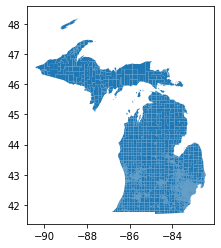

In [69]:
join = gpd.GeoDataFrame(pd.merge(df_with_avcb_and_stat_reallocated, shp, on = 'VTD2016', how = 'outer').drop_duplicates(), crs = crs)
join.plot()

In [70]:
join.shape

(4811, 42)

# Validation

## Shapefile

In [77]:
shp_final_merge = pd.merge(join, gdfv, on = 'VTD2016', how = 'outer', suffixes = ['_x', '_y'], indicator = True)

In [78]:
join['geometry'].geom_almost_equals(gdfv['geometry'], decimal = 0)

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0       False
1       False
2       False
3       False
4       False
        ...  
4806    False
4807    False
4808    False
4809    False
4810    False
Length: 4811, dtype: bool

In [79]:
shp_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_x')
final_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_y')
vals = shp_shapes.geom_almost_equals(final_shapes, decimal = 0)

In [80]:
print(vals.value_counts())

True     4758
False      53
dtype: int64


In [82]:
both = shp_final_merge[shp_final_merge["_merge"]=="both"]
source_geoms = gpd.GeoDataFrame(both,geometry="geometry_x",crs=gdfv.crs)
vest_geoms = gpd.GeoDataFrame(both,geometry="geometry_y",crs=gdfv.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    4810
dtype: int64


In [83]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > 1):
        count += 1
        name = source_geoms.at[i,"join_col"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [84]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and 0.1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=0.1)]))+ " precincts w/ a difference between 0.1 and 0.5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=0.5)]))+ " precincts w/ a difference between 0.5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(4810, 1)
0 precincts w/ a difference of 0 km^2
4810 precincts w/ a difference between 0 and 0.1 km^2
0 precincts w/ a difference between 0.1 and 0.5 km^2
0 precincts w/ a difference between 0.5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2


# Election result difference

In [88]:
validater_row(shp_final_merge, column_list)

G16PREDCli ...........................................................0276090000001 (V) ..279  (S)..539 (D):  260
G16PRERTru ...........................................................0276090000001 (V) ..736  (S).1272 (D):  536
G16PREDCli ...........................................................0277394000001 (V) ..264  (S)..445 (D):  181
G16PRERTru ...........................................................0277394000001 (V) ..739  (S)..998 (D):  259
G16PREDCli ...........................................................0452452000001 (V) ..618  (S)..290 (D): -328
G16PRERTru ...........................................................0452452000001 (V) .1027  (S)..554 (D): -473
G16PREDCli ...........................................................0452452000002 (V) ..165  (S)..449 (D):  284
G16PRERTru ...........................................................0452452000002 (V) ..361  (S)..751 (D):  390
G16PREDCli ...........................................................0452456000001 (V) 

- Peter tries some unique id then take what joins off of that
- if incorrect join it will come up later when you compare precinct by precinct election results
- for stuff that does not join, export to csv and look at that - manually line up
- map unique ids from one to the other to match
- rerunning the join - then left with the stuff where you have no idea where it is coming from
- if there are no unique ids at all, but you are able to 
